In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from pathlib import Path
from save_experiment import save_experiment
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tqdm import tqdm
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
import warnings

In [2]:
df = pd.read_csv('../processed_data/hp_energy_production_with_engineered_features_1.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df.dropna()
df = df[df['Station'] == 'Amberd1']

features = [
    'Water_Flow_m3_s', 'avgtempC', 'totalprecipMM', 'humidity', 'pressureMB',
    'Month', 'WaterFlow_Diff_1d', 'WaterFlow_Diff_7d', 'WaterFlow_3day_avg',
    'WaterFlow_7day_avg', 'Temp_Deviation', 'WaterFlow_Humidity',
    'month_sin', 'month_cos', 'Prev_Day_Efficiency', 'Prev_Week_Efficiency'
]
target = 'Normalized_Efficiency'

In [3]:
df_num = df.select_dtypes(include=['number']).dropna()
X = df_num.drop(columns=['Normalized_Efficiency'])
y = df_num['Normalized_Efficiency']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [4]:
models = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "RandomForest": RandomForestRegressor(random_state=42),
    "XGBoost": XGBRegressor(n_estimators=500, max_depth=10, learning_rate=0.05, random_state=42, verbosity=0),
    "LightGBM": LGBMRegressor(n_estimators=500, max_depth=10, learning_rate=0.05, random_state=42, verbose=-1),
    "CatBoost": CatBoostRegressor(n_estimators=500, depth=10, learning_rate=0.05, random_state=42, verbose=0),
    "GradientBoosting": GradientBoostingRegressor(random_state=42),
    "Support Vector Regression": SVR(),
    "K-Nearest Neighbors": KNeighborsRegressor(n_neighbors=10),
    "AdaBoost": AdaBoostRegressor(random_state=42),
    "DecisionTree": DecisionTreeRegressor(random_state=42),
    "Multiple Linear Regression (MLR)": LinearRegression(),
    "SVR": SVR()
}

In [5]:
results = {}

for name, model in tqdm(models.items()):
    if name in ['MLP Regressor']:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
    
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    results[name] = {
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R2': r2,
        'Prediction': y_pred
    }

/Users/elvinanosrati/Capstone/energy-production-analysis/myenv-py311/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=1.09916e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.28it/s]


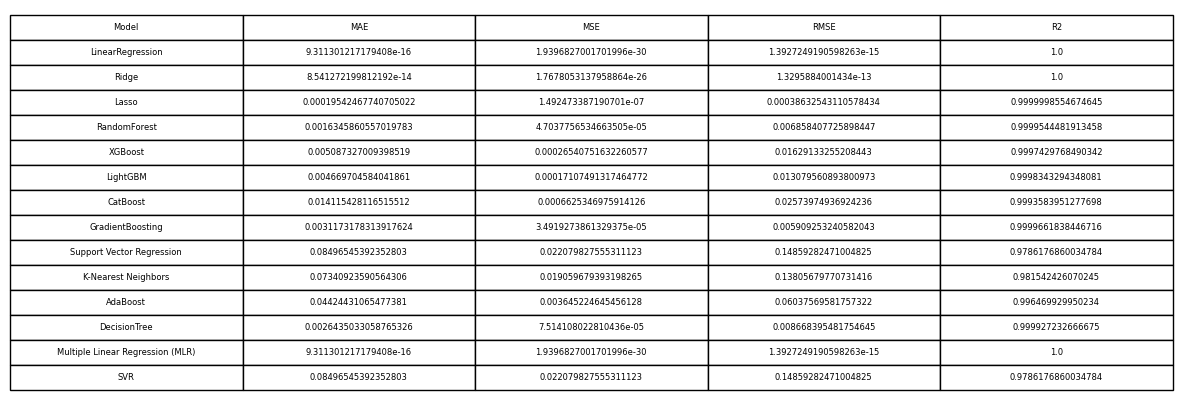

In [6]:
metrics_df = pd.DataFrame({
    'Model': list(results.keys()),
    'MAE': [results[m]['MAE'] for m in results],
    'MSE': [results[m]['MSE'] for m in results],
    'RMSE': [results[m]['RMSE'] for m in results],
    'R2': [results[m]['R2'] for m in results]
})

fig, ax = plt.subplots(figsize=(10,5))
ax.axis('off')
table = ax.table(cellText=metrics_df.values, colLabels=metrics_df.columns, cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(6)
table.scale(1.5, 1.5)
plt.show()

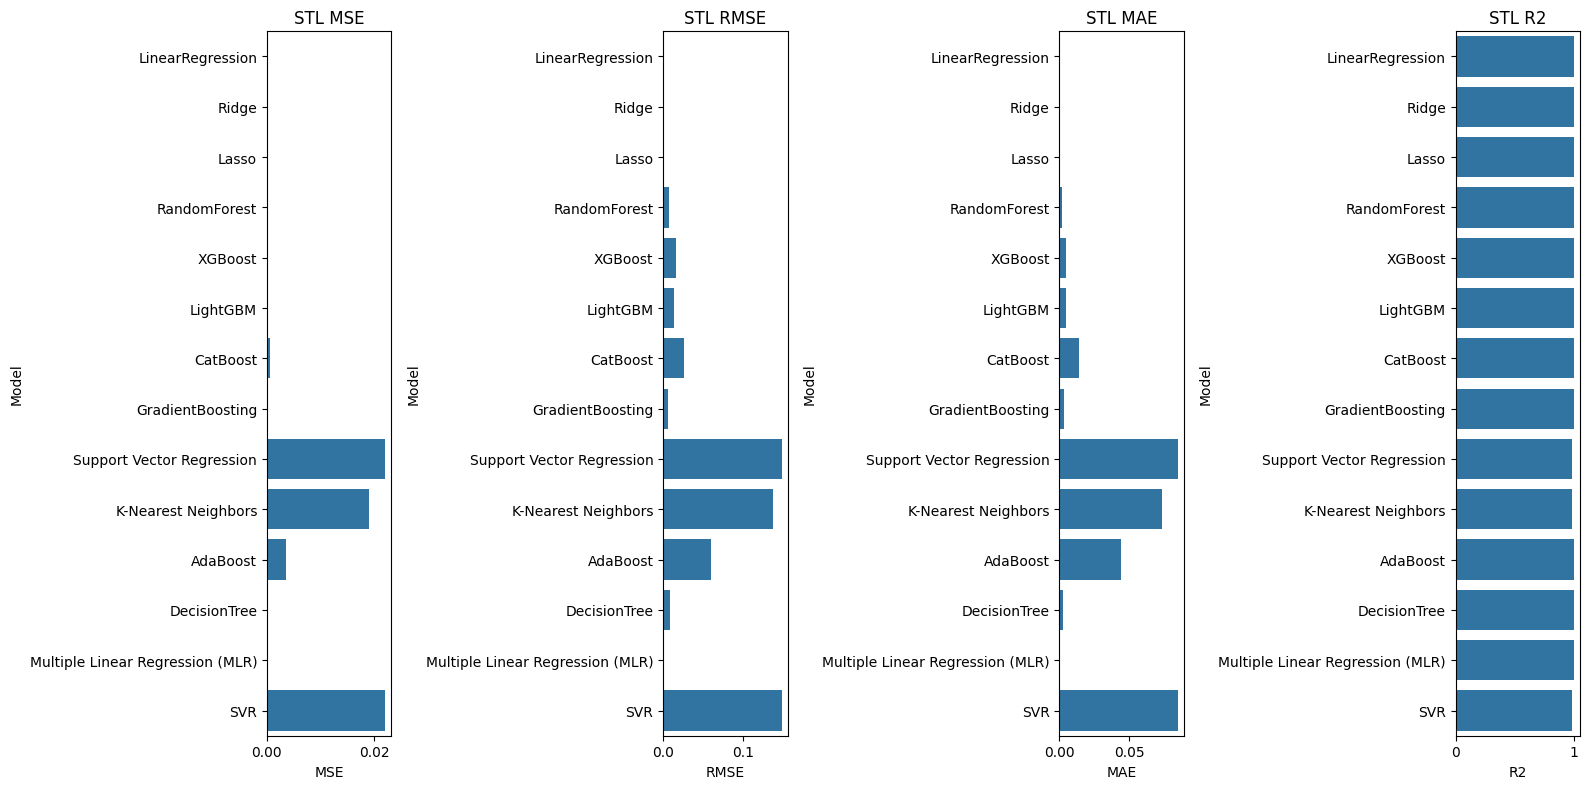

In [7]:
plt.figure(figsize=(16, 8))
for i, metric in enumerate(["MSE", "RMSE", "MAE", "R2"]):
    plt.subplot(1, 4, i + 1)
    sns.barplot(y="Model", x=metric, data=metrics_df)
    plt.title("STL " + metric)
    plt.tight_layout()
plt.show()

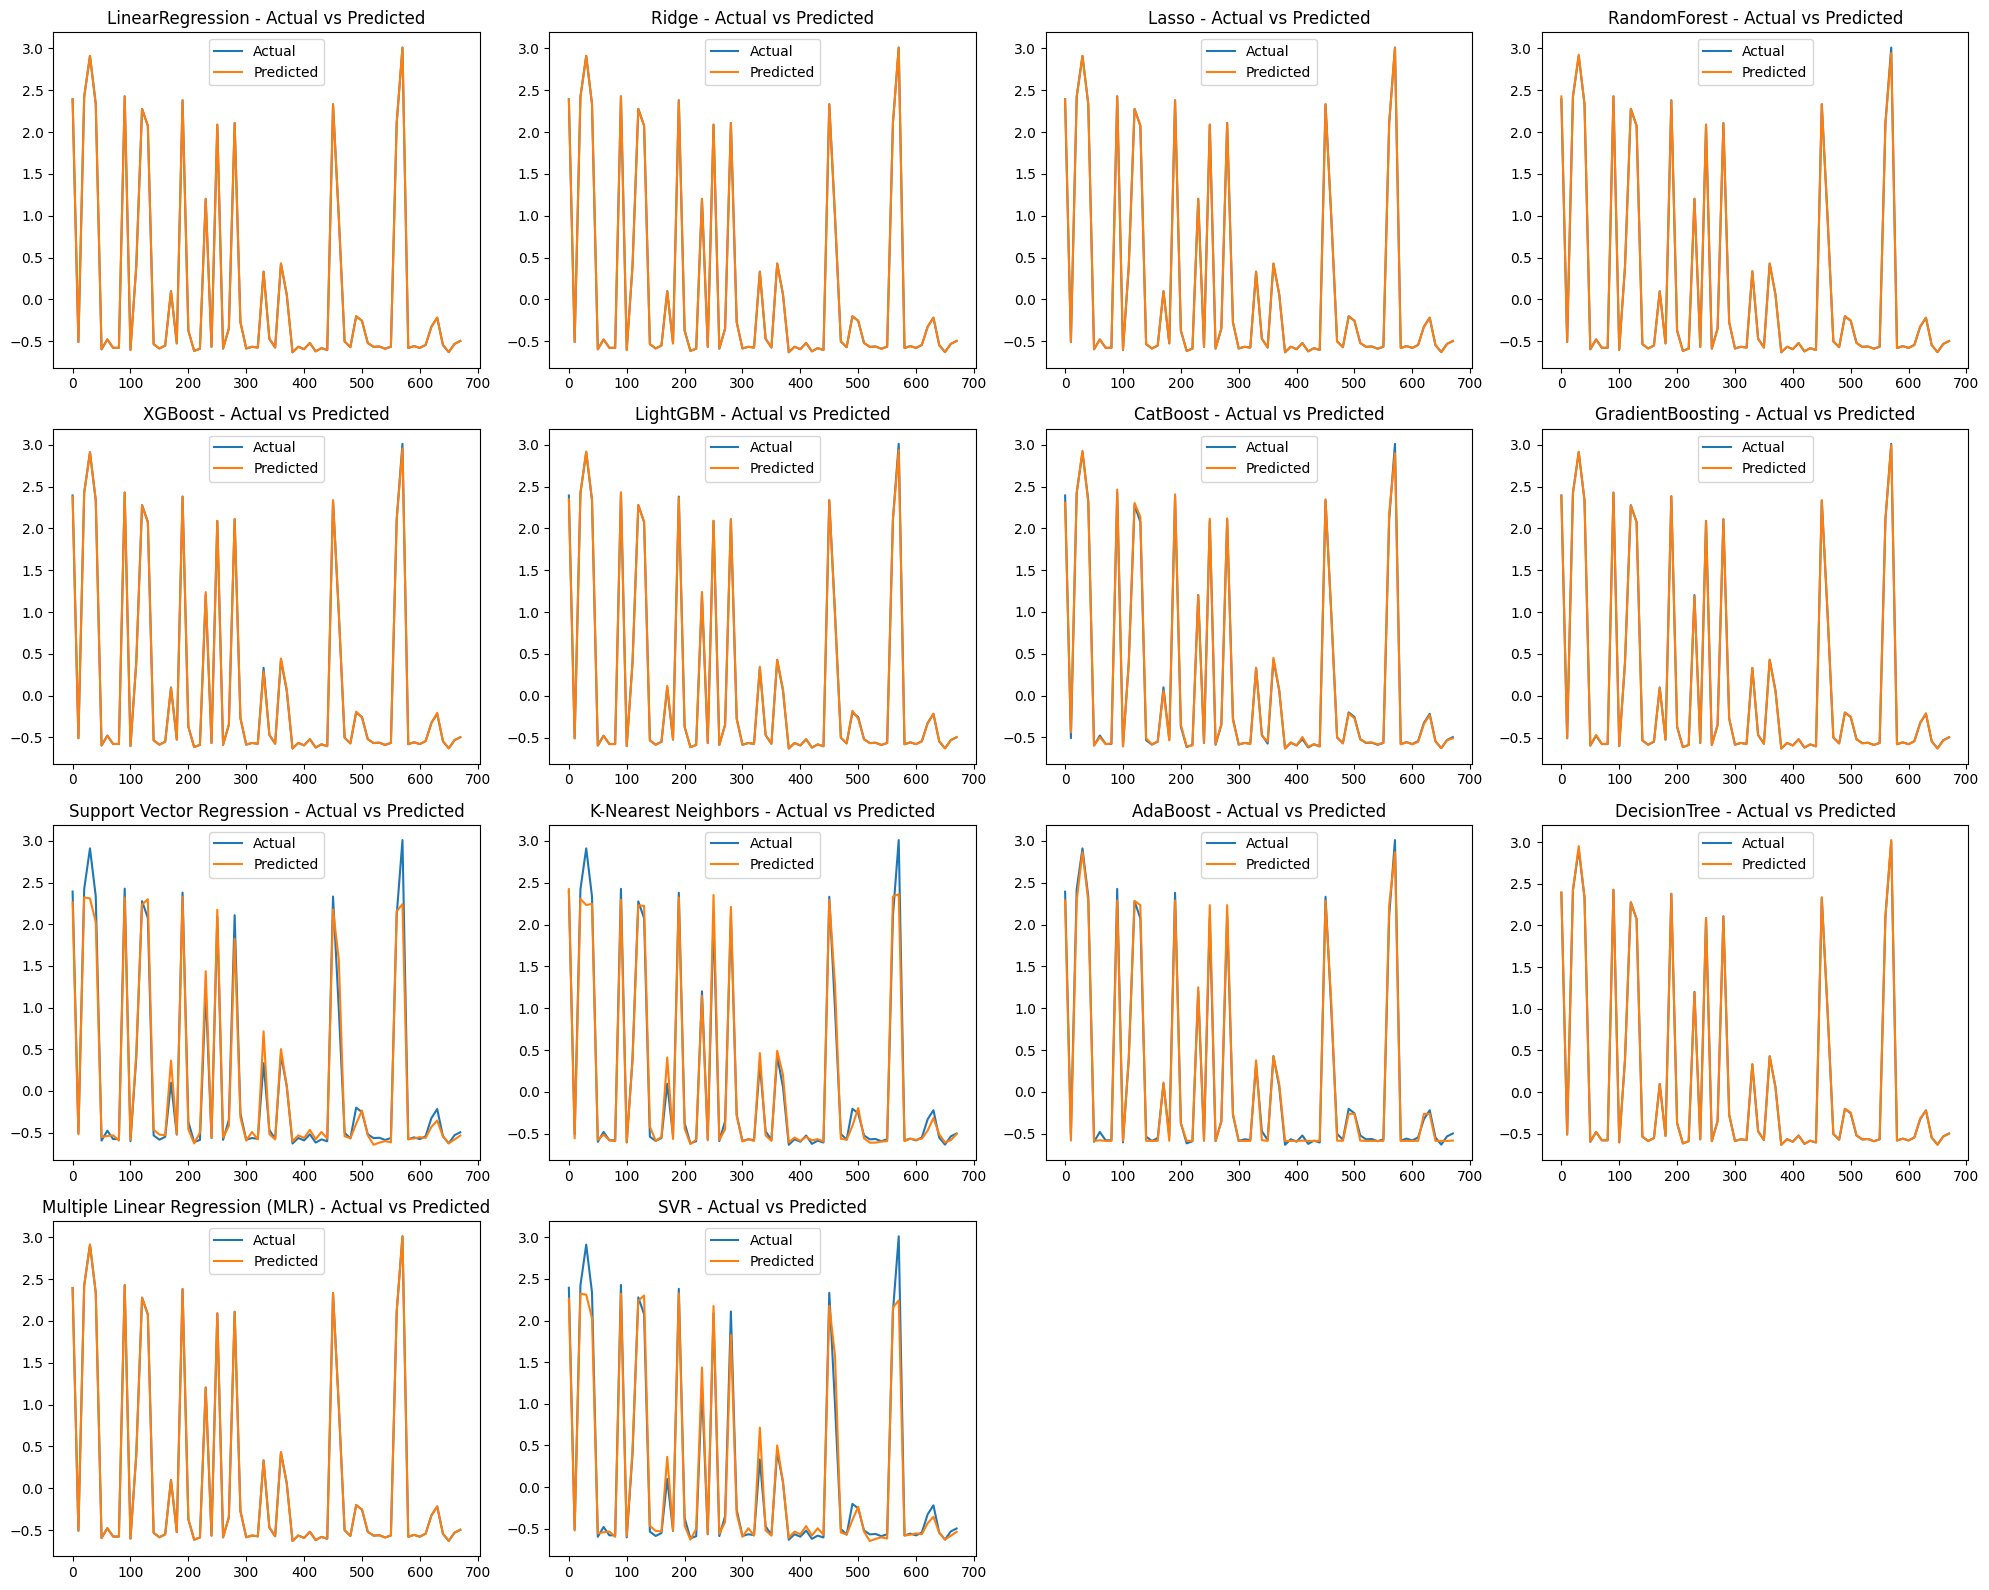

In [8]:
cols_stl      = 4
num_models_stl = len(results)
rows_stl      = int(np.ceil(num_models_stl / cols_stl))

idx = np.arange(len(y_test))[::10]

plt.figure(figsize=(20, 16))
for i, (name, res) in enumerate(results.items()):
    ax = plt.subplot(rows_stl, cols_stl, i + 1)
    ax.plot(idx, y_test.values[idx],        label='Actual')
    ax.plot(idx, res['Prediction'][idx],    label='Predicted')
    ax.set_title(f"{name} - Actual vs Predicted")
    ax.legend()
plt.tight_layout()
plt.show()

In [9]:
X_tensor = torch.tensor(X.values, dtype=torch.float32)
y_tensor = torch.tensor(y.values, dtype=torch.float32).view(-1, 1)

X_train_tensor           = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_tensor            = torch.tensor(X_test_scaled,  dtype=torch.float32)
X_train_tensor_tabular = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_tensor_tabular  = torch.tensor(X_test_scaled,  dtype=torch.float32)
y_train_tensor           = torch.tensor(y_train.values,    dtype=torch.float32).view(-1, 1)
y_test_tensor            = torch.tensor(y_test.values,     dtype=torch.float32).view(-1, 1)

train_dataset            = TensorDataset(X_train_tensor,        y_train_tensor)
test_dataset             = TensorDataset(X_test_tensor,         y_test_tensor)  

train_dataset_tabular    = TensorDataset(X_train_tensor_tabular, y_train_tensor)
test_dataset_tabular     = TensorDataset(X_test_tensor_tabular,  y_test_tensor)

train_loader             = DataLoader(train_dataset,          batch_size=64,  shuffle=True)
test_loader              = DataLoader(test_dataset,           batch_size=64,  shuffle=False)
train_loader_tabular     = DataLoader(train_dataset_tabular,  batch_size=256, shuffle=True)
test_loader_tabular      = DataLoader(test_dataset_tabular,   batch_size=256, shuffle=False)

In [10]:
def reshape_input(model, xb):
    rnn_models = (LSTMNet, BiLSTMNet, RNNNet, GRUNet, CNNLSTM, DeepLSTMNet, Seq2SeqLSTM, CNNBiLSTM, GRUCNN)
    cnn_models = (CNN1D, CNNLSTM, CNNBiLSTM, GRUCNN)
    tcn_models = (TCN, TCNLSTM)

    if isinstance(model, tcn_models):
        if xb.dim() == 2:
            xb = xb.unsqueeze(-1)
            xb = xb.transpose(1, 2)
    elif isinstance(model, rnn_models + cnn_models):
        if xb.dim() == 2:
            xb = xb.unsqueeze(1)
    return xb

In [11]:
class Net1(nn.Module):
    def __init__(self, input_dim):
        super(Net1, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.net(x)


class Net2(nn.Module):
    def __init__(self, input_dim):
        super(Net2, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.net(x)


class Net3(nn.Module):
    def __init__(self, input_dim):
        super(Net3, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.net(x)

class Net4(nn.Module):
    def __init__(self, input_dim):
        super(Net4, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(128, 64),
            nn.ReLU(),

            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.net(x)

In [12]:
class LSTMNet(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=2):
        super(LSTMNet, self).__init__()
        self.lstm = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])


class BiLSTMNet(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=2, dropout=0.3):
        super(BiLSTMNet, self).__init__()
        self.lstm = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim, num_layers=num_layers,
                            dropout=dropout, batch_first=True, bidirectional=True)
        self.fc = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(hidden_dim * 2, 1)
        )

    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])


class RNNNet(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=2):
        super(RNNNet, self).__init__()
        self.rnn = nn.RNN(input_size=input_dim, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        out, _ = self.rnn(x)
        return self.fc(out[:, -1, :])


class GRUNet(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=2):
        super(GRUNet, self).__init__()
        self.gru = nn.GRU(input_size=input_dim, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        out, _ = self.gru(x)
        return self.fc(out[:, -1, :])

class CNN1D(nn.Module):
    def __init__(self, input_dim, num_filters, num_layers, kernel_size, dropout):
        super().__init__()
        layers = []
        in_ch = input_dim
        for _ in range(num_layers):
            layers += [
                nn.Conv1d(in_ch, num_filters, kernel_size, padding=kernel_size//2),
                nn.ReLU(),
                nn.Dropout(dropout)
            ]
            in_ch = num_filters
        self.features = nn.Sequential(*layers)
        self.fc = nn.Linear(num_filters, 1)

    def forward(self, x):
        x = x.transpose(1, 2)
        out = self.features(x)
        out = out.mean(dim=2)
        return self.fc(out)


class CNNLSTM(nn.Module):
    def __init__(
        self,
        input_dim: int,
        cnn_filters: list[int] = [64, 64],
        cnn_kernel_size: int = 3,
        lstm_hidden: int = 128,
        lstm_layers: int = 2,
        dropout: float = 0.3
    ):
        super().__init__()
        if isinstance(cnn_filters, int):
            cnn_filters = [cnn_filters]
        convs, in_ch = [], 1
        for out_ch in cnn_filters:
            convs += [
                nn.Conv1d(in_ch, out_ch, kernel_size=cnn_kernel_size,
                          padding=cnn_kernel_size//2),
                nn.ReLU(),
                nn.Dropout(dropout)
            ]
            in_ch = out_ch
        self.cnn = nn.Sequential(*convs)
        self.lstm = nn.LSTM(
            input_size=in_ch,
            hidden_size=lstm_hidden,
            num_layers=lstm_layers,
            batch_first=True,
            dropout=dropout if lstm_layers > 1 else 0.0
        )
        self.head = nn.Linear(lstm_hidden, 1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if x.dim() == 4:
            x = x.squeeze(1)

        if x.dim() == 2:
            b, f = x.shape
            x = x.unsqueeze(1)       
            x = self.cnn(x)          
            x = x.transpose(1, 2)     
            out, _ = self.lstm(x)     
            return self.head(out[:, -1, :])

        elif x.dim() == 3:
            b, s, f = x.shape
            x = x.reshape(b * s, f).unsqueeze(1)  
            x = self.cnn(x)                      
            x = x.mean(dim=2)                     
            x = x.view(b, s, -1)                  
            out, _ = self.lstm(x)                 
            return self.head(out[:, -1, :])

        else:
            raise ValueError(f"Unsupported input dims: {x.dim()}")


class FNN(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.net(x)

class DeepFNN(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(32, 1)
        )
    def forward(self, x):
        return self.net(x)

class DeepLSTMNet(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, num_layers=4, dropout=0.3):
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_dim,
                            hidden_size=hidden_dim,
                            num_layers=num_layers,
                            batch_first=True,
                            dropout=dropout)
        self.fc = nn.Linear(hidden_dim, 1)
    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

class TemporalBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, dilation, padding, dropout):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size,
                               stride=stride, padding=padding, dilation=dilation)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size,
                               stride=stride, padding=padding, dilation=dilation)

        self.downsample = (nn.Conv1d(in_channels, out_channels, 1)
                           if in_channels != out_channels else None)
        self.relu = nn.ReLU()

    def forward(self, x):
        L = x.size(2) 
        out = self.conv1(x)[..., :L]    
        out = self.bn1(out); out = self.relu(out); out = self.dropout1(out)

        out = self.conv2(out)[..., :L]
        out = self.bn2(out); out = self.relu(out); out = self.dropout2(out)

        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)


class TemporalBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size,
                 stride, dilation, dropout):
        super().__init__()
        padding = (kernel_size - 1) * dilation // 2

        self.conv1 = nn.Conv1d(
            in_channels, out_channels, kernel_size,
            stride=stride, padding=padding, dilation=dilation
        )
        self.bn1      = nn.BatchNorm1d(out_channels)
        self.relu1    = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)

        self.conv2 = nn.Conv1d(
            out_channels, out_channels, kernel_size,
            stride=stride, padding=padding, dilation=dilation
        )
        self.bn2      = nn.BatchNorm1d(out_channels)
        self.relu2    = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)

        self.downsample = (
            nn.Conv1d(in_channels, out_channels, 1)
            if in_channels != out_channels else None
        )
        self.final_relu = nn.ReLU()

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu1(out)
        out = self.dropout1(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu2(out)
        out = self.dropout2(out)

        res = x if self.downsample is None else self.downsample(x)
        return self.final_relu(out + res)


class TCN(nn.Module):
    def __init__(self, input_dim, num_channels, kernel_size=3, dropout=0.2):
        super().__init__()
        layers = []
        for i, out_ch in enumerate(num_channels):
            in_ch   = input_dim if i == 0 else num_channels[i-1]
            dilation = 2 ** i
            layers.append(
                TemporalBlock(
                    in_channels=in_ch,
                    out_channels=out_ch,
                    kernel_size=kernel_size,
                    stride=1,
                    dilation=dilation,
                    dropout=dropout
                )
            )
        self.network = nn.Sequential(*layers)
        self.fc      = nn.Linear(num_channels[-1], 1)

    def forward(self, x):
        x = x.transpose(1, 2)     
        y = self.network(x)       
        y = y[:, :, -1]           
        return self.fc(y)    

class CNNBiLSTM(nn.Module):
    def __init__(self, input_dim, cnn_filters=32, lstm_hidden=64, lstm_layers=2, dropout=0.3):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv1d(input_dim, cnn_filters, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        self.bilstm = nn.LSTM(
            input_size=cnn_filters,
            hidden_size=lstm_hidden,
            num_layers=lstm_layers,
            batch_first=True,
            bidirectional=True,
            dropout=dropout
        )
        self.fc = nn.Linear(2 * lstm_hidden, 1)

    def forward(self, x):
        x = x.transpose(1, 2)
        x = self.cnn(x)
        x = x.transpose(1, 2)
        out, _ = self.bilstm(x)
        return self.fc(out[:, -1, :])

class GRUCNN(nn.Module):
    def __init__(self, input_dim, gru_hidden=64, cnn_filters=32, kernel_size=3, dropout=0.3):
        super().__init__()
        self.gru = nn.GRU(input_dim, gru_hidden, batch_first=True)
        self.cnn = nn.Sequential(
            nn.Conv1d(gru_hidden, cnn_filters, kernel_size=kernel_size, padding=1),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        self.fc = nn.Linear(cnn_filters, 1)

    def forward(self, x):
        out, _ = self.gru(x)
        out = self.cnn(out.transpose(1, 2))
        out = out.mean(dim=2)
        return self.fc(out)

class TCNLSTM(nn.Module):
    def __init__(self, input_dim, tcn_channels=[64,64], lstm_hidden=64, lstm_layers=1, kernel_size=3, dropout=0.3):
        super().__init__()
        self.tcn = TCN(input_dim, tcn_channels, kernel_size=kernel_size, dropout=dropout)
        self.lstm = nn.LSTM(input_size=tcn_channels[-1], hidden_size=lstm_hidden, num_layers=lstm_layers, batch_first=True)
        self.fc = nn.Linear(lstm_hidden, 1)

    def forward(self, x):
        x = x.transpose(1, 2)
        x = self.tcn.network(x).transpose(1, 2)
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

class Seq2SeqLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=2, dropout=0.3):
        super(Seq2SeqLSTM, self).__init__()
        self.encoder = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers, dropout=dropout, batch_first=True)
        self.decoder = nn.LSTM(hidden_dim, hidden_dim, num_layers=num_layers, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        _, (hidden, cell) = self.encoder(x)
        dec_input = torch.zeros(x.size(0), 1, hidden.size(2)).to(x.device)
        out, _ = self.decoder(dec_input, (hidden, cell))
        return self.fc(out[:, -1, :])
  

In [13]:
def train_model(name, model, train_loader, X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor,epochs=1000, lr=1e-3):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    history = []
    for epoch in tqdm(range(1, epochs + 1)):
        model.train()
        running_loss = 0
        for xb, yb in train_loader:
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
        
        model.eval()
        with torch.no_grad():
            y_train_pred = model(X_train_tensor)
            y_test_pred  = model(X_test_tensor)

            train_mse  = mean_squared_error(y_train_tensor.numpy(), y_train_pred.numpy())
            test_mse   = mean_squared_error(y_test_tensor.numpy(), y_test_pred.numpy())
            train_rmse = np.sqrt(train_mse)
            test_rmse  = np.sqrt(test_mse)
            train_mae  = mean_absolute_error(y_train_tensor.numpy(), y_train_pred.numpy())
            test_mae   = mean_absolute_error(y_test_tensor.numpy(), y_test_pred.numpy())
            train_r2   = r2_score(y_train_tensor.numpy(), y_train_pred.numpy())
            test_r2    = r2_score(y_test_tensor.numpy(), y_test_pred.numpy())

            history.append({
                "Model": name,
                "Epoch": epoch,
                "Train MSE": train_mse,
                "Test MSE": test_mse,
                "Train RMSE": train_rmse,
                "Test RMSE": test_rmse,
                "Train MAE": train_mae,
                "Test MAE": test_mae,
                "Train R2": train_r2,
                "Test R2": test_r2
            })

            if epoch % 10 == 0 or epoch == 1 or epoch == epochs:
                print(f"\nModel: {name} | Epoch: {epoch}/{epochs}")
                print(f"Train: MSE: {train_mse:.4f}, RMSE: {train_rmse:.4f}, MAE: {train_mae:.4f}, R2: {train_r2:.4f}")
                print(f"Test:  MSE: {test_mse:.4f}, RMSE: {test_rmse:.4f}, MAE: {test_mae:.4f}, R2: {test_r2:.4f}")
                
    return history

In [14]:
def train_ts_model(name, model, train_loader, X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor, epochs=200, lr=1e-3):
    criterion = nn.MSELoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)

    history = []
    for epoch in tqdm(range(1, epochs + 1), desc=f"Training {name}"):
        model.train()
        running_loss = 0
        for xb, yb in train_loader:
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()    
            running_loss += loss.item()

        model.eval()
        with torch.no_grad():
            y_train_pred = model(X_train_tensor)
            y_test_pred  = model(X_test_tensor)

            train_mse = mean_squared_error(y_train_tensor.numpy(), y_train_pred.numpy())
            test_mse  = mean_squared_error(y_test_tensor.numpy(), y_test_pred.numpy())
            train_rmse = np.sqrt(train_mse)
            test_rmse  = np.sqrt(test_mse)
            train_mae = mean_absolute_error(y_train_tensor.numpy(), y_train_pred.numpy())
            test_mae  = mean_absolute_error(y_test_tensor.numpy(), y_test_pred.numpy())
            train_r2  = r2_score(y_train_tensor.numpy(), y_train_pred.numpy())
            test_r2   = r2_score(y_test_tensor.numpy(), y_test_pred.numpy())

            history.append({
                "Model": name,
                "Epoch": epoch,
                "Train MSE": train_mse,
                "Test MSE": test_mse,
                "Train RMSE": train_rmse,
                "Test RMSE": test_rmse,
                "Train MAE": train_mae,
                "Test MAE": test_mae,
                "Train R2": train_r2,
                "Test R2": test_r2
            })

            if epoch % 10 == 0 or epoch == 1 or epoch == epochs:
                print(f"\nModel: {name} | Epoch: {epoch}/{epochs}")
                print(f"Train: MSE: {train_mse:.4f}, RMSE: {train_rmse:.4f}, MAE: {train_mae:.4f}, R2: {train_r2:.4f}")
                print(f"Test:  MSE: {test_mse:.4f}, RMSE: {test_rmse:.4f}, MAE: {test_mae:.4f}, R2: {test_r2:.4f}")

    return history

In [15]:
input_dim = X_test_tensor_tabular.shape[1]

nets = {
    "Net1":   Net1(input_dim),
    "Net2":   Net2(input_dim),
    "Net3":   Net3(input_dim),
    "Net4":   Net4(input_dim)
}

nets_tabular = {
    "Net1":    Net1(input_dim),
    "Net2":    Net2(input_dim),
    "Net3":    Net3(input_dim),
    "Net4":    Net4(input_dim),
    "FNN":     FNN(input_dim),
    "DeepFNN": DeepFNN(input_dim)
}

In [16]:
results = []
for name, net in nets.items():
    results += train_model(name, net, train_loader, 
                               X_train_tensor, y_train_tensor, 
                               X_test_tensor, y_test_tensor,
                               epochs=100, lr=1e-3)
    
nn_metrics_df = pd.DataFrame(results)

  5%|█████▏                                                                                                 | 5/100 [00:00<00:04, 19.15it/s]


Model: Net1 | Epoch: 1/100
Train: MSE: 0.2882, RMSE: 0.5369, MAE: 0.3189, R2: 0.7094
Test:  MSE: 0.2995, RMSE: 0.5472, MAE: 0.3343, R2: 0.7100


 13%|█████████████▎                                                                                        | 13/100 [00:00<00:03, 27.15it/s]


Model: Net1 | Epoch: 10/100
Train: MSE: 0.0012, RMSE: 0.0348, MAE: 0.0252, R2: 0.9988
Test:  MSE: 0.0013, RMSE: 0.0356, MAE: 0.0260, R2: 0.9988


 21%|█████████████████████▍                                                                                | 21/100 [00:00<00:02, 30.20it/s]


Model: Net1 | Epoch: 20/100
Train: MSE: 0.0006, RMSE: 0.0238, MAE: 0.0174, R2: 0.9994
Test:  MSE: 0.0006, RMSE: 0.0249, MAE: 0.0181, R2: 0.9994


 34%|██████████████████████████████████▋                                                                   | 34/100 [00:01<00:03, 21.53it/s]


Model: Net1 | Epoch: 30/100
Train: MSE: 0.0003, RMSE: 0.0182, MAE: 0.0133, R2: 0.9997
Test:  MSE: 0.0004, RMSE: 0.0196, MAE: 0.0139, R2: 0.9996


 43%|███████████████████████████████████████████▊                                                          | 43/100 [00:01<00:02, 22.90it/s]


Model: Net1 | Epoch: 40/100
Train: MSE: 0.0002, RMSE: 0.0154, MAE: 0.0113, R2: 0.9998
Test:  MSE: 0.0003, RMSE: 0.0178, MAE: 0.0130, R2: 0.9997


 52%|█████████████████████████████████████████████████████                                                 | 52/100 [00:02<00:02, 22.62it/s]


Model: Net1 | Epoch: 50/100
Train: MSE: 0.0002, RMSE: 0.0139, MAE: 0.0104, R2: 0.9998
Test:  MSE: 0.0003, RMSE: 0.0164, MAE: 0.0118, R2: 0.9997


 64%|█████████████████████████████████████████████████████████████████▎                                    | 64/100 [00:02<00:01, 23.77it/s]


Model: Net1 | Epoch: 60/100
Train: MSE: 0.0002, RMSE: 0.0129, MAE: 0.0100, R2: 0.9998
Test:  MSE: 0.0002, RMSE: 0.0153, MAE: 0.0114, R2: 0.9998


 73%|██████████████████████████████████████████████████████████████████████████▍                           | 73/100 [00:03<00:01, 24.02it/s]


Model: Net1 | Epoch: 70/100
Train: MSE: 0.0001, RMSE: 0.0111, MAE: 0.0082, R2: 0.9999
Test:  MSE: 0.0002, RMSE: 0.0138, MAE: 0.0101, R2: 0.9998


 82%|███████████████████████████████████████████████████████████████████████████████████▋                  | 82/100 [00:03<00:00, 23.68it/s]


Model: Net1 | Epoch: 80/100
Train: MSE: 0.0001, RMSE: 0.0104, MAE: 0.0078, R2: 0.9999
Test:  MSE: 0.0002, RMSE: 0.0130, MAE: 0.0093, R2: 0.9998


 94%|███████████████████████████████████████████████████████████████████████████████████████████████▉      | 94/100 [00:04<00:00, 22.79it/s]


Model: Net1 | Epoch: 90/100
Train: MSE: 0.0001, RMSE: 0.0091, MAE: 0.0068, R2: 0.9999
Test:  MSE: 0.0001, RMSE: 0.0121, MAE: 0.0087, R2: 0.9999


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 22.78it/s]



Model: Net1 | Epoch: 100/100
Train: MSE: 0.0001, RMSE: 0.0087, MAE: 0.0064, R2: 0.9999
Test:  MSE: 0.0001, RMSE: 0.0112, MAE: 0.0079, R2: 0.9999


  2%|██                                                                                                     | 2/100 [00:00<00:05, 16.97it/s]


Model: Net2 | Epoch: 1/100
Train: MSE: 0.0149, RMSE: 0.1222, MAE: 0.0885, R2: 0.9849
Test:  MSE: 0.0135, RMSE: 0.1161, MAE: 0.0841, R2: 0.9869


 12%|████████████▏                                                                                         | 12/100 [00:00<00:04, 17.93it/s]


Model: Net2 | Epoch: 10/100
Train: MSE: 0.0003, RMSE: 0.0172, MAE: 0.0125, R2: 0.9997
Test:  MSE: 0.0004, RMSE: 0.0198, MAE: 0.0143, R2: 0.9996


 22%|██████████████████████▍                                                                               | 22/100 [00:01<00:04, 17.05it/s]


Model: Net2 | Epoch: 20/100
Train: MSE: 0.0001, RMSE: 0.0110, MAE: 0.0082, R2: 0.9999
Test:  MSE: 0.0002, RMSE: 0.0147, MAE: 0.0103, R2: 0.9998


 32%|████████████████████████████████▋                                                                     | 32/100 [00:01<00:03, 18.74it/s]


Model: Net2 | Epoch: 30/100
Train: MSE: 0.0001, RMSE: 0.0087, MAE: 0.0066, R2: 0.9999
Test:  MSE: 0.0002, RMSE: 0.0124, MAE: 0.0086, R2: 0.9999


 42%|██████████████████████████████████████████▊                                                           | 42/100 [00:02<00:03, 18.96it/s]


Model: Net2 | Epoch: 40/100
Train: MSE: 0.0001, RMSE: 0.0094, MAE: 0.0069, R2: 0.9999
Test:  MSE: 0.0002, RMSE: 0.0128, MAE: 0.0088, R2: 0.9998


 52%|█████████████████████████████████████████████████████                                                 | 52/100 [00:02<00:02, 18.65it/s]


Model: Net2 | Epoch: 50/100
Train: MSE: 0.0001, RMSE: 0.0078, MAE: 0.0061, R2: 0.9999
Test:  MSE: 0.0001, RMSE: 0.0116, MAE: 0.0082, R2: 0.9999


 62%|███████████████████████████████████████████████████████████████▏                                      | 62/100 [00:03<00:02, 18.18it/s]


Model: Net2 | Epoch: 60/100
Train: MSE: 0.0001, RMSE: 0.0095, MAE: 0.0078, R2: 0.9999
Test:  MSE: 0.0001, RMSE: 0.0119, MAE: 0.0093, R2: 0.9999


 74%|███████████████████████████████████████████████████████████████████████████▍                          | 74/100 [00:04<00:01, 19.75it/s]


Model: Net2 | Epoch: 70/100
Train: MSE: 0.0001, RMSE: 0.0095, MAE: 0.0073, R2: 0.9999
Test:  MSE: 0.0002, RMSE: 0.0125, MAE: 0.0089, R2: 0.9998


 83%|████████████████████████████████████████████████████████████████████████████████████▋                 | 83/100 [00:04<00:00, 19.73it/s]


Model: Net2 | Epoch: 80/100
Train: MSE: 0.0001, RMSE: 0.0109, MAE: 0.0084, R2: 0.9999
Test:  MSE: 0.0002, RMSE: 0.0129, MAE: 0.0098, R2: 0.9998


 94%|███████████████████████████████████████████████████████████████████████████████████████████████▉      | 94/100 [00:05<00:00, 19.63it/s]


Model: Net2 | Epoch: 90/100
Train: MSE: 0.0001, RMSE: 0.0077, MAE: 0.0058, R2: 0.9999
Test:  MSE: 0.0001, RMSE: 0.0106, MAE: 0.0074, R2: 0.9999


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 18.63it/s]



Model: Net2 | Epoch: 100/100
Train: MSE: 0.0000, RMSE: 0.0050, MAE: 0.0038, R2: 1.0000
Test:  MSE: 0.0001, RMSE: 0.0087, MAE: 0.0058, R2: 0.9999


  2%|██                                                                                                     | 2/100 [00:00<00:06, 15.23it/s]


Model: Net3 | Epoch: 1/100
Train: MSE: 0.0079, RMSE: 0.0890, MAE: 0.0660, R2: 0.9920
Test:  MSE: 0.0082, RMSE: 0.0908, MAE: 0.0682, R2: 0.9920


 12%|████████████▏                                                                                         | 12/100 [00:00<00:05, 15.12it/s]


Model: Net3 | Epoch: 10/100
Train: MSE: 0.0003, RMSE: 0.0169, MAE: 0.0131, R2: 0.9997
Test:  MSE: 0.0003, RMSE: 0.0180, MAE: 0.0136, R2: 0.9997


 22%|██████████████████████▍                                                                               | 22/100 [00:01<00:05, 15.18it/s]


Model: Net3 | Epoch: 20/100
Train: MSE: 0.0001, RMSE: 0.0099, MAE: 0.0079, R2: 0.9999
Test:  MSE: 0.0002, RMSE: 0.0127, MAE: 0.0098, R2: 0.9998


 32%|████████████████████████████████▋                                                                     | 32/100 [00:02<00:04, 15.16it/s]


Model: Net3 | Epoch: 30/100
Train: MSE: 0.0001, RMSE: 0.0084, MAE: 0.0062, R2: 0.9999
Test:  MSE: 0.0001, RMSE: 0.0113, MAE: 0.0078, R2: 0.9999


 42%|██████████████████████████████████████████▊                                                           | 42/100 [00:02<00:03, 15.29it/s]


Model: Net3 | Epoch: 40/100
Train: MSE: 0.0001, RMSE: 0.0114, MAE: 0.0092, R2: 0.9999
Test:  MSE: 0.0002, RMSE: 0.0135, MAE: 0.0102, R2: 0.9998


 52%|█████████████████████████████████████████████████████                                                 | 52/100 [00:03<00:03, 15.30it/s]


Model: Net3 | Epoch: 50/100
Train: MSE: 0.0003, RMSE: 0.0171, MAE: 0.0113, R2: 0.9997
Test:  MSE: 0.0003, RMSE: 0.0178, MAE: 0.0120, R2: 0.9997


 62%|███████████████████████████████████████████████████████████████▏                                      | 62/100 [00:04<00:02, 14.93it/s]


Model: Net3 | Epoch: 60/100
Train: MSE: 0.0001, RMSE: 0.0075, MAE: 0.0056, R2: 0.9999
Test:  MSE: 0.0001, RMSE: 0.0100, MAE: 0.0070, R2: 0.9999


 72%|█████████████████████████████████████████████████████████████████████████▍                            | 72/100 [00:04<00:01, 15.05it/s]


Model: Net3 | Epoch: 70/100
Train: MSE: 0.0000, RMSE: 0.0059, MAE: 0.0044, R2: 1.0000
Test:  MSE: 0.0001, RMSE: 0.0087, MAE: 0.0061, R2: 0.9999


 82%|███████████████████████████████████████████████████████████████████████████████████▋                  | 82/100 [00:05<00:01, 15.26it/s]


Model: Net3 | Epoch: 80/100
Train: MSE: 0.0001, RMSE: 0.0080, MAE: 0.0061, R2: 0.9999
Test:  MSE: 0.0001, RMSE: 0.0099, MAE: 0.0071, R2: 0.9999


 92%|█████████████████████████████████████████████████████████████████████████████████████████████▊        | 92/100 [00:06<00:00, 15.33it/s]


Model: Net3 | Epoch: 90/100
Train: MSE: 0.0000, RMSE: 0.0056, MAE: 0.0040, R2: 1.0000
Test:  MSE: 0.0001, RMSE: 0.0081, MAE: 0.0052, R2: 0.9999


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.19it/s]



Model: Net3 | Epoch: 100/100
Train: MSE: 0.0001, RMSE: 0.0085, MAE: 0.0063, R2: 0.9999
Test:  MSE: 0.0001, RMSE: 0.0101, MAE: 0.0073, R2: 0.9999


  1%|█                                                                                                      | 1/100 [00:00<00:14,  6.81it/s]


Model: Net4 | Epoch: 1/100
Train: MSE: 0.0067, RMSE: 0.0821, MAE: 0.0596, R2: 0.9932
Test:  MSE: 0.0067, RMSE: 0.0821, MAE: 0.0593, R2: 0.9935


 11%|███████████▏                                                                                          | 11/100 [00:01<00:12,  6.93it/s]


Model: Net4 | Epoch: 10/100
Train: MSE: 0.0090, RMSE: 0.0948, MAE: 0.0651, R2: 0.9909
Test:  MSE: 0.0089, RMSE: 0.0943, MAE: 0.0650, R2: 0.9914


 21%|█████████████████████▍                                                                                | 21/100 [00:03<00:11,  6.88it/s]


Model: Net4 | Epoch: 20/100
Train: MSE: 0.0048, RMSE: 0.0696, MAE: 0.0538, R2: 0.9951
Test:  MSE: 0.0049, RMSE: 0.0698, MAE: 0.0538, R2: 0.9953


 31%|███████████████████████████████▌                                                                      | 31/100 [00:04<00:09,  6.95it/s]


Model: Net4 | Epoch: 30/100
Train: MSE: 0.0048, RMSE: 0.0691, MAE: 0.0527, R2: 0.9952
Test:  MSE: 0.0047, RMSE: 0.0683, MAE: 0.0524, R2: 0.9955


 41%|█████████████████████████████████████████▊                                                            | 41/100 [00:05<00:08,  6.95it/s]


Model: Net4 | Epoch: 40/100
Train: MSE: 0.0107, RMSE: 0.1037, MAE: 0.0674, R2: 0.9892
Test:  MSE: 0.0108, RMSE: 0.1038, MAE: 0.0691, R2: 0.9896


 51%|████████████████████████████████████████████████████                                                  | 51/100 [00:07<00:07,  6.72it/s]


Model: Net4 | Epoch: 50/100
Train: MSE: 0.0029, RMSE: 0.0541, MAE: 0.0441, R2: 0.9970
Test:  MSE: 0.0029, RMSE: 0.0534, MAE: 0.0429, R2: 0.9972


 61%|██████████████████████████████████████████████████████████████▏                                       | 61/100 [00:09<00:05,  6.90it/s]


Model: Net4 | Epoch: 60/100
Train: MSE: 0.0164, RMSE: 0.1279, MAE: 0.0795, R2: 0.9835
Test:  MSE: 0.0161, RMSE: 0.1270, MAE: 0.0810, R2: 0.9844


 71%|████████████████████████████████████████████████████████████████████████▍                             | 71/100 [00:10<00:04,  6.84it/s]


Model: Net4 | Epoch: 70/100
Train: MSE: 0.0159, RMSE: 0.1260, MAE: 0.0746, R2: 0.9840
Test:  MSE: 0.0160, RMSE: 0.1266, MAE: 0.0766, R2: 0.9845


 81%|██████████████████████████████████████████████████████████████████████████████████▌                   | 81/100 [00:12<00:03,  5.83it/s]


Model: Net4 | Epoch: 80/100
Train: MSE: 0.0085, RMSE: 0.0923, MAE: 0.0666, R2: 0.9914
Test:  MSE: 0.0086, RMSE: 0.0927, MAE: 0.0672, R2: 0.9917


 90%|███████████████████████████████████████████████████████████████████████████████████████████▊          | 90/100 [00:13<00:01,  5.65it/s]


Model: Net4 | Epoch: 90/100
Train: MSE: 0.0160, RMSE: 0.1264, MAE: 0.0845, R2: 0.9839
Test:  MSE: 0.0161, RMSE: 0.1270, MAE: 0.0858, R2: 0.9844


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.31it/s]


Model: Net4 | Epoch: 100/100
Train: MSE: 0.0075, RMSE: 0.0869, MAE: 0.0562, R2: 0.9924
Test:  MSE: 0.0076, RMSE: 0.0871, MAE: 0.0565, R2: 0.9927


In [17]:
results_tabular = []
for name, net in nets_tabular.items():
    results_tabular += train_model(
        name, net, train_loader_tabular,
        X_train_tensor_tabular, y_train_tensor,
        X_test_tensor_tabular,  y_test_tensor,
        epochs=100, lr=1e-3
    )
nn_metrics_df_tabular = pd.DataFrame(results_tabular)

  4%|████                                                                                                   | 4/100 [00:00<00:02, 34.44it/s]


Model: Net1 | Epoch: 1/100
Train: MSE: 0.4851, RMSE: 0.6965, MAE: 0.4197, R2: 0.5109
Test:  MSE: 0.5080, RMSE: 0.7127, MAE: 0.4285, R2: 0.5081


 15%|███████████████▎                                                                                      | 15/100 [00:00<00:02, 28.81it/s]


Model: Net1 | Epoch: 10/100
Train: MSE: 0.0087, RMSE: 0.0931, MAE: 0.0683, R2: 0.9913
Test:  MSE: 0.0074, RMSE: 0.0860, MAE: 0.0639, R2: 0.9928


 27%|███████████████████████████▌                                                                          | 27/100 [00:00<00:02, 34.18it/s]


Model: Net1 | Epoch: 20/100
Train: MSE: 0.0020, RMSE: 0.0443, MAE: 0.0325, R2: 0.9980
Test:  MSE: 0.0021, RMSE: 0.0455, MAE: 0.0338, R2: 0.9980


 35%|███████████████████████████████████▋                                                                  | 35/100 [00:01<00:01, 34.71it/s]


Model: Net1 | Epoch: 30/100
Train: MSE: 0.0012, RMSE: 0.0346, MAE: 0.0254, R2: 0.9988
Test:  MSE: 0.0014, RMSE: 0.0378, MAE: 0.0277, R2: 0.9986


 47%|███████████████████████████████████████████████▉                                                      | 47/100 [00:01<00:01, 36.09it/s]


Model: Net1 | Epoch: 40/100
Train: MSE: 0.0008, RMSE: 0.0289, MAE: 0.0212, R2: 0.9992
Test:  MSE: 0.0011, RMSE: 0.0330, MAE: 0.0239, R2: 0.9989


 55%|████████████████████████████████████████████████████████                                              | 55/100 [00:01<00:01, 36.32it/s]


Model: Net1 | Epoch: 50/100
Train: MSE: 0.0006, RMSE: 0.0252, MAE: 0.0185, R2: 0.9994
Test:  MSE: 0.0009, RMSE: 0.0293, MAE: 0.0208, R2: 0.9992


 63%|████████████████████████████████████████████████████████████████▎                                     | 63/100 [00:01<00:01, 35.80it/s]


Model: Net1 | Epoch: 60/100
Train: MSE: 0.0005, RMSE: 0.0224, MAE: 0.0162, R2: 0.9995
Test:  MSE: 0.0007, RMSE: 0.0266, MAE: 0.0183, R2: 0.9993


 75%|████████████████████████████████████████████████████████████████████████████▌                         | 75/100 [00:02<00:00, 33.50it/s]


Model: Net1 | Epoch: 70/100
Train: MSE: 0.0004, RMSE: 0.0205, MAE: 0.0148, R2: 0.9996
Test:  MSE: 0.0006, RMSE: 0.0250, MAE: 0.0170, R2: 0.9994


 87%|████████████████████████████████████████████████████████████████████████████████████████▋             | 87/100 [00:02<00:00, 34.75it/s]


Model: Net1 | Epoch: 80/100
Train: MSE: 0.0004, RMSE: 0.0190, MAE: 0.0138, R2: 0.9996
Test:  MSE: 0.0006, RMSE: 0.0235, MAE: 0.0160, R2: 0.9995


 95%|████████████████████████████████████████████████████████████████████████████████████████████████▉     | 95/100 [00:02<00:00, 35.55it/s]


Model: Net1 | Epoch: 90/100
Train: MSE: 0.0003, RMSE: 0.0176, MAE: 0.0127, R2: 0.9997
Test:  MSE: 0.0005, RMSE: 0.0226, MAE: 0.0151, R2: 0.9995


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 34.43it/s]



Model: Net1 | Epoch: 100/100
Train: MSE: 0.0003, RMSE: 0.0165, MAE: 0.0120, R2: 0.9997
Test:  MSE: 0.0005, RMSE: 0.0216, MAE: 0.0145, R2: 0.9995


  3%|███                                                                                                    | 3/100 [00:00<00:03, 29.88it/s]


Model: Net2 | Epoch: 1/100
Train: MSE: 0.2355, RMSE: 0.4853, MAE: 0.3522, R2: 0.7625
Test:  MSE: 0.2451, RMSE: 0.4951, MAE: 0.3598, R2: 0.7626


 15%|███████████████▎                                                                                      | 15/100 [00:00<00:02, 31.33it/s]


Model: Net2 | Epoch: 10/100
Train: MSE: 0.0017, RMSE: 0.0409, MAE: 0.0299, R2: 0.9983
Test:  MSE: 0.0018, RMSE: 0.0428, MAE: 0.0317, R2: 0.9982


 23%|███████████████████████▍                                                                              | 23/100 [00:00<00:02, 31.55it/s]


Model: Net2 | Epoch: 20/100
Train: MSE: 0.0007, RMSE: 0.0261, MAE: 0.0191, R2: 0.9993
Test:  MSE: 0.0008, RMSE: 0.0288, MAE: 0.0209, R2: 0.9992


 35%|███████████████████████████████████▋                                                                  | 35/100 [00:01<00:02, 31.83it/s]


Model: Net2 | Epoch: 30/100
Train: MSE: 0.0004, RMSE: 0.0204, MAE: 0.0148, R2: 0.9996
Test:  MSE: 0.0006, RMSE: 0.0239, MAE: 0.0168, R2: 0.9994


 43%|███████████████████████████████████████████▊                                                          | 43/100 [00:01<00:01, 31.83it/s]


Model: Net2 | Epoch: 40/100
Train: MSE: 0.0003, RMSE: 0.0170, MAE: 0.0124, R2: 0.9997
Test:  MSE: 0.0004, RMSE: 0.0209, MAE: 0.0145, R2: 0.9996


 55%|████████████████████████████████████████████████████████                                              | 55/100 [00:01<00:01, 31.73it/s]


Model: Net2 | Epoch: 50/100
Train: MSE: 0.0002, RMSE: 0.0146, MAE: 0.0105, R2: 0.9998
Test:  MSE: 0.0004, RMSE: 0.0188, MAE: 0.0131, R2: 0.9997


 63%|████████████████████████████████████████████████████████████████▎                                     | 63/100 [00:01<00:01, 31.54it/s]


Model: Net2 | Epoch: 60/100
Train: MSE: 0.0002, RMSE: 0.0131, MAE: 0.0095, R2: 0.9998
Test:  MSE: 0.0003, RMSE: 0.0174, MAE: 0.0120, R2: 0.9997


 75%|████████████████████████████████████████████████████████████████████████████▌                         | 75/100 [00:02<00:00, 31.42it/s]


Model: Net2 | Epoch: 70/100
Train: MSE: 0.0001, RMSE: 0.0116, MAE: 0.0084, R2: 0.9999
Test:  MSE: 0.0003, RMSE: 0.0162, MAE: 0.0111, R2: 0.9997


 83%|████████████████████████████████████████████████████████████████████████████████████▋                 | 83/100 [00:02<00:00, 31.46it/s]


Model: Net2 | Epoch: 80/100
Train: MSE: 0.0001, RMSE: 0.0107, MAE: 0.0078, R2: 0.9999
Test:  MSE: 0.0002, RMSE: 0.0155, MAE: 0.0104, R2: 0.9998


 87%|████████████████████████████████████████████████████████████████████████████████████████▋             | 87/100 [00:02<00:00, 31.70it/s]


Model: Net2 | Epoch: 90/100
Train: MSE: 0.0001, RMSE: 0.0096, MAE: 0.0071, R2: 0.9999
Test:  MSE: 0.0002, RMSE: 0.0145, MAE: 0.0097, R2: 0.9998


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 29.55it/s]



Model: Net2 | Epoch: 100/100
Train: MSE: 0.0001, RMSE: 0.0088, MAE: 0.0064, R2: 0.9999
Test:  MSE: 0.0002, RMSE: 0.0140, MAE: 0.0093, R2: 0.9998


  3%|███                                                                                                    | 3/100 [00:00<00:03, 25.78it/s]


Model: Net3 | Epoch: 1/100
Train: MSE: 0.0624, RMSE: 0.2497, MAE: 0.1747, R2: 0.9371
Test:  MSE: 0.0585, RMSE: 0.2418, MAE: 0.1694, R2: 0.9434


 15%|███████████████▎                                                                                      | 15/100 [00:00<00:03, 25.59it/s]


Model: Net3 | Epoch: 10/100
Train: MSE: 0.0013, RMSE: 0.0357, MAE: 0.0267, R2: 0.9987
Test:  MSE: 0.0015, RMSE: 0.0382, MAE: 0.0279, R2: 0.9986


 24%|████████████████████████▍                                                                             | 24/100 [00:00<00:02, 25.73it/s]


Model: Net3 | Epoch: 20/100
Train: MSE: 0.0005, RMSE: 0.0213, MAE: 0.0151, R2: 0.9995
Test:  MSE: 0.0005, RMSE: 0.0215, MAE: 0.0158, R2: 0.9996


 33%|█████████████████████████████████▋                                                                    | 33/100 [00:01<00:02, 25.99it/s]


Model: Net3 | Epoch: 30/100
Train: MSE: 0.0003, RMSE: 0.0161, MAE: 0.0118, R2: 0.9997
Test:  MSE: 0.0003, RMSE: 0.0169, MAE: 0.0124, R2: 0.9997


 45%|█████████████████████████████████████████████▉                                                        | 45/100 [00:01<00:02, 25.94it/s]


Model: Net3 | Epoch: 40/100
Train: MSE: 0.0002, RMSE: 0.0131, MAE: 0.0097, R2: 0.9998
Test:  MSE: 0.0002, RMSE: 0.0143, MAE: 0.0105, R2: 0.9998


 54%|███████████████████████████████████████████████████████                                               | 54/100 [00:02<00:01, 26.27it/s]


Model: Net3 | Epoch: 50/100
Train: MSE: 0.0002, RMSE: 0.0123, MAE: 0.0102, R2: 0.9998
Test:  MSE: 0.0002, RMSE: 0.0142, MAE: 0.0112, R2: 0.9998


 63%|████████████████████████████████████████████████████████████████▎                                     | 63/100 [00:02<00:01, 26.21it/s]


Model: Net3 | Epoch: 60/100
Train: MSE: 0.0001, RMSE: 0.0089, MAE: 0.0065, R2: 0.9999
Test:  MSE: 0.0001, RMSE: 0.0113, MAE: 0.0081, R2: 0.9999


 75%|████████████████████████████████████████████████████████████████████████████▌                         | 75/100 [00:02<00:00, 25.70it/s]


Model: Net3 | Epoch: 70/100
Train: MSE: 0.0000, RMSE: 0.0071, MAE: 0.0052, R2: 0.9999
Test:  MSE: 0.0001, RMSE: 0.0102, MAE: 0.0069, R2: 0.9999


 84%|█████████████████████████████████████████████████████████████████████████████████████▋                | 84/100 [00:03<00:00, 25.97it/s]


Model: Net3 | Epoch: 80/100
Train: MSE: 0.0000, RMSE: 0.0069, MAE: 0.0051, R2: 1.0000
Test:  MSE: 0.0001, RMSE: 0.0102, MAE: 0.0069, R2: 0.9999


 93%|██████████████████████████████████████████████████████████████████████████████████████████████▊       | 93/100 [00:03<00:00, 26.30it/s]


Model: Net3 | Epoch: 90/100
Train: MSE: 0.0001, RMSE: 0.0080, MAE: 0.0065, R2: 0.9999
Test:  MSE: 0.0001, RMSE: 0.0107, MAE: 0.0079, R2: 0.9999


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 25.99it/s]



Model: Net3 | Epoch: 100/100
Train: MSE: 0.0000, RMSE: 0.0057, MAE: 0.0043, R2: 1.0000
Test:  MSE: 0.0001, RMSE: 0.0092, MAE: 0.0063, R2: 0.9999


  2%|██                                                                                                     | 2/100 [00:00<00:08, 11.91it/s]


Model: Net4 | Epoch: 1/100
Train: MSE: 0.0714, RMSE: 0.2673, MAE: 0.2281, R2: 0.9280
Test:  MSE: 0.0711, RMSE: 0.2667, MAE: 0.2251, R2: 0.9311


 12%|████████████▏                                                                                         | 12/100 [00:01<00:07, 11.93it/s]


Model: Net4 | Epoch: 10/100
Train: MSE: 0.0050, RMSE: 0.0706, MAE: 0.0483, R2: 0.9950
Test:  MSE: 0.0056, RMSE: 0.0750, MAE: 0.0512, R2: 0.9946


 22%|██████████████████████▍                                                                               | 22/100 [00:01<00:06, 12.20it/s]


Model: Net4 | Epoch: 20/100
Train: MSE: 0.0021, RMSE: 0.0463, MAE: 0.0379, R2: 0.9978
Test:  MSE: 0.0023, RMSE: 0.0479, MAE: 0.0374, R2: 0.9978


 32%|████████████████████████████████▋                                                                     | 32/100 [00:02<00:05, 12.08it/s]


Model: Net4 | Epoch: 30/100
Train: MSE: 0.0156, RMSE: 0.1248, MAE: 0.0741, R2: 0.9843
Test:  MSE: 0.0168, RMSE: 0.1295, MAE: 0.0786, R2: 0.9838


 42%|██████████████████████████████████████████▊                                                           | 42/100 [00:03<00:04, 12.06it/s]


Model: Net4 | Epoch: 40/100
Train: MSE: 0.0036, RMSE: 0.0598, MAE: 0.0459, R2: 0.9964
Test:  MSE: 0.0037, RMSE: 0.0611, MAE: 0.0454, R2: 0.9964


 52%|█████████████████████████████████████████████████████                                                 | 52/100 [00:04<00:04, 11.47it/s]


Model: Net4 | Epoch: 50/100
Train: MSE: 0.0089, RMSE: 0.0946, MAE: 0.0688, R2: 0.9910
Test:  MSE: 0.0090, RMSE: 0.0949, MAE: 0.0685, R2: 0.9913


 62%|███████████████████████████████████████████████████████████████▏                                      | 62/100 [00:05<00:03, 11.66it/s]


Model: Net4 | Epoch: 60/100
Train: MSE: 0.0036, RMSE: 0.0600, MAE: 0.0493, R2: 0.9964
Test:  MSE: 0.0035, RMSE: 0.0590, MAE: 0.0480, R2: 0.9966


 70%|███████████████████████████████████████████████████████████████████████▍                              | 70/100 [00:05<00:02, 11.74it/s]


Model: Net4 | Epoch: 70/100
Train: MSE: 0.0059, RMSE: 0.0766, MAE: 0.0501, R2: 0.9941
Test:  MSE: 0.0060, RMSE: 0.0771, MAE: 0.0510, R2: 0.9942


 82%|███████████████████████████████████████████████████████████████████████████████████▋                  | 82/100 [00:06<00:01, 11.87it/s]


Model: Net4 | Epoch: 80/100
Train: MSE: 0.0061, RMSE: 0.0784, MAE: 0.0601, R2: 0.9938
Test:  MSE: 0.0061, RMSE: 0.0783, MAE: 0.0603, R2: 0.9941


 92%|█████████████████████████████████████████████████████████████████████████████████████████████▊        | 92/100 [00:07<00:00, 11.43it/s]


Model: Net4 | Epoch: 90/100
Train: MSE: 0.0043, RMSE: 0.0653, MAE: 0.0495, R2: 0.9957
Test:  MSE: 0.0041, RMSE: 0.0644, MAE: 0.0490, R2: 0.9960


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 11.64it/s]



Model: Net4 | Epoch: 100/100
Train: MSE: 0.0085, RMSE: 0.0924, MAE: 0.0647, R2: 0.9914
Test:  MSE: 0.0086, RMSE: 0.0927, MAE: 0.0663, R2: 0.9917


  3%|███                                                                                                    | 3/100 [00:00<00:03, 24.97it/s]


Model: FNN | Epoch: 1/100
Train: MSE: 0.4672, RMSE: 0.6835, MAE: 0.5301, R2: 0.5289
Test:  MSE: 0.4861, RMSE: 0.6972, MAE: 0.5335, R2: 0.5293


 15%|███████████████▎                                                                                      | 15/100 [00:00<00:03, 28.20it/s]


Model: FNN | Epoch: 10/100
Train: MSE: 0.0106, RMSE: 0.1031, MAE: 0.0744, R2: 0.9893
Test:  MSE: 0.0096, RMSE: 0.0982, MAE: 0.0707, R2: 0.9907


 24%|████████████████████████▍                                                                             | 24/100 [00:00<00:02, 28.62it/s]


Model: FNN | Epoch: 20/100
Train: MSE: 0.0086, RMSE: 0.0929, MAE: 0.0666, R2: 0.9913
Test:  MSE: 0.0086, RMSE: 0.0925, MAE: 0.0665, R2: 0.9917


 33%|█████████████████████████████████▋                                                                    | 33/100 [00:01<00:02, 28.56it/s]


Model: FNN | Epoch: 30/100
Train: MSE: 0.0101, RMSE: 0.1003, MAE: 0.0678, R2: 0.9899
Test:  MSE: 0.0108, RMSE: 0.1041, MAE: 0.0713, R2: 0.9895


 45%|█████████████████████████████████████████████▉                                                        | 45/100 [00:01<00:01, 28.49it/s]


Model: FNN | Epoch: 40/100
Train: MSE: 0.0058, RMSE: 0.0759, MAE: 0.0536, R2: 0.9942
Test:  MSE: 0.0061, RMSE: 0.0780, MAE: 0.0546, R2: 0.9941


 54%|███████████████████████████████████████████████████████                                               | 54/100 [00:01<00:01, 28.74it/s]


Model: FNN | Epoch: 50/100
Train: MSE: 0.0048, RMSE: 0.0689, MAE: 0.0485, R2: 0.9952
Test:  MSE: 0.0052, RMSE: 0.0723, MAE: 0.0503, R2: 0.9949


 63%|████████████████████████████████████████████████████████████████▎                                     | 63/100 [00:02<00:01, 28.82it/s]


Model: FNN | Epoch: 60/100
Train: MSE: 0.0050, RMSE: 0.0707, MAE: 0.0507, R2: 0.9950
Test:  MSE: 0.0056, RMSE: 0.0747, MAE: 0.0533, R2: 0.9946


 75%|████████████████████████████████████████████████████████████████████████████▌                         | 75/100 [00:02<00:00, 29.01it/s]


Model: FNN | Epoch: 70/100
Train: MSE: 0.0036, RMSE: 0.0596, MAE: 0.0432, R2: 0.9964
Test:  MSE: 0.0039, RMSE: 0.0623, MAE: 0.0446, R2: 0.9962


 84%|█████████████████████████████████████████████████████████████████████████████████████▋                | 84/100 [00:02<00:00, 28.86it/s]


Model: FNN | Epoch: 80/100
Train: MSE: 0.0050, RMSE: 0.0708, MAE: 0.0488, R2: 0.9949
Test:  MSE: 0.0057, RMSE: 0.0753, MAE: 0.0515, R2: 0.9945


 93%|██████████████████████████████████████████████████████████████████████████████████████████████▊       | 93/100 [00:03<00:00, 28.90it/s]


Model: FNN | Epoch: 90/100
Train: MSE: 0.0041, RMSE: 0.0639, MAE: 0.0443, R2: 0.9959
Test:  MSE: 0.0047, RMSE: 0.0682, MAE: 0.0476, R2: 0.9955


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 28.59it/s]



Model: FNN | Epoch: 100/100
Train: MSE: 0.0044, RMSE: 0.0661, MAE: 0.0458, R2: 0.9956
Test:  MSE: 0.0049, RMSE: 0.0699, MAE: 0.0487, R2: 0.9953


  3%|███                                                                                                    | 3/100 [00:00<00:03, 26.23it/s]


Model: DeepFNN | Epoch: 1/100
Train: MSE: 0.6289, RMSE: 0.7931, MAE: 0.4736, R2: 0.3658
Test:  MSE: 0.6720, RMSE: 0.8197, MAE: 0.4900, R2: 0.3493


 15%|███████████████▎                                                                                      | 15/100 [00:00<00:03, 25.82it/s]


Model: DeepFNN | Epoch: 10/100
Train: MSE: 0.0098, RMSE: 0.0988, MAE: 0.0712, R2: 0.9901
Test:  MSE: 0.0108, RMSE: 0.1041, MAE: 0.0758, R2: 0.9895


 24%|████████████████████████▍                                                                             | 24/100 [00:00<00:02, 25.63it/s]


Model: DeepFNN | Epoch: 20/100
Train: MSE: 0.0126, RMSE: 0.1121, MAE: 0.0792, R2: 0.9873
Test:  MSE: 0.0141, RMSE: 0.1186, MAE: 0.0848, R2: 0.9864


 33%|█████████████████████████████████▋                                                                    | 33/100 [00:01<00:02, 25.90it/s]


Model: DeepFNN | Epoch: 30/100
Train: MSE: 0.0089, RMSE: 0.0945, MAE: 0.0653, R2: 0.9910
Test:  MSE: 0.0103, RMSE: 0.1014, MAE: 0.0703, R2: 0.9900


 45%|█████████████████████████████████████████████▉                                                        | 45/100 [00:01<00:02, 26.02it/s]


Model: DeepFNN | Epoch: 40/100
Train: MSE: 0.0087, RMSE: 0.0934, MAE: 0.0620, R2: 0.9912
Test:  MSE: 0.0097, RMSE: 0.0984, MAE: 0.0645, R2: 0.9906


 54%|███████████████████████████████████████████████████████                                               | 54/100 [00:02<00:01, 25.98it/s]


Model: DeepFNN | Epoch: 50/100
Train: MSE: 0.0027, RMSE: 0.0516, MAE: 0.0413, R2: 0.9973
Test:  MSE: 0.0028, RMSE: 0.0533, MAE: 0.0417, R2: 0.9972


 63%|████████████████████████████████████████████████████████████████▎                                     | 63/100 [00:02<00:01, 26.02it/s]


Model: DeepFNN | Epoch: 60/100
Train: MSE: 0.0031, RMSE: 0.0558, MAE: 0.0423, R2: 0.9969
Test:  MSE: 0.0034, RMSE: 0.0587, MAE: 0.0437, R2: 0.9967


 72%|█████████████████████████████████████████████████████████████████████████▍                            | 72/100 [00:02<00:01, 25.76it/s]


Model: DeepFNN | Epoch: 70/100
Train: MSE: 0.0025, RMSE: 0.0496, MAE: 0.0391, R2: 0.9975
Test:  MSE: 0.0027, RMSE: 0.0519, MAE: 0.0391, R2: 0.9974


 84%|█████████████████████████████████████████████████████████████████████████████████████▋                | 84/100 [00:03<00:00, 23.09it/s]


Model: DeepFNN | Epoch: 80/100
Train: MSE: 0.0036, RMSE: 0.0599, MAE: 0.0426, R2: 0.9964
Test:  MSE: 0.0040, RMSE: 0.0633, MAE: 0.0436, R2: 0.9961


 93%|██████████████████████████████████████████████████████████████████████████████████████████████▊       | 93/100 [00:03<00:00, 22.59it/s]


Model: DeepFNN | Epoch: 90/100
Train: MSE: 0.0052, RMSE: 0.0721, MAE: 0.0521, R2: 0.9948
Test:  MSE: 0.0059, RMSE: 0.0765, MAE: 0.0539, R2: 0.9943


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 24.54it/s]


Model: DeepFNN | Epoch: 100/100
Train: MSE: 0.0021, RMSE: 0.0462, MAE: 0.0350, R2: 0.9978
Test:  MSE: 0.0024, RMSE: 0.0489, MAE: 0.0358, R2: 0.9977


In [18]:
cols = ["Model", "Epoch", "Train MSE", "Test MSE", "Train RMSE", "Test RMSE", 
        "Train MAE", "Test MAE", "Train R2", "Test R2"]

best_idx = nn_metrics_df.groupby("Model")["Test R2"].idxmax()
best_results = nn_metrics_df.loc[best_idx].reset_index(drop=True)
best_results = best_results[cols]

best_idx_tab = nn_metrics_df_tabular.groupby("Model")["Test R2"].idxmax()
best_results_tab = nn_metrics_df_tabular.loc[best_idx_tab].reset_index(drop=True)
best_results_tab = best_results_tab[cols]

In [19]:
best_results

Model  Epoch  Train MSE  Test MSE  Train RMSE  Test RMSE  Train MAE  \
0  Net1    100   0.000076  0.000125    0.008693   0.011177   0.006375   
1  Net2    100   0.000025  0.000076    0.005038   0.008699   0.003800   
2  Net3     90   0.000031  0.000066    0.005559   0.008130   0.004000   
3  Net4     21   0.002480  0.002663    0.049798   0.051605   0.038052   

   Test MAE  Train R2   Test R2  
0  0.007923  0.999924  0.999879  
1  0.005761  0.999974  0.999927  
2  0.005197  0.999969  0.999936  
3  0.038873  0.997499  0.997421

In [20]:
best_results_tab

Model  Epoch  Train MSE  Test MSE  Train RMSE  Test RMSE  Train MAE  \
0  DeepFNN     45   0.001865  0.002015    0.043185   0.044889   0.032176   
1      FNN     89   0.002724  0.003019    0.052188   0.054944   0.037017   
2     Net1    100   0.000274  0.000466    0.016548   0.021586   0.012014   
3     Net2    100   0.000078  0.000197    0.008838   0.014019   0.006436   
4     Net3    100   0.000033  0.000084    0.005745   0.009160   0.004283   
5     Net4     61   0.001544  0.001579    0.039299   0.039735   0.032163   

   Test MAE  Train R2   Test R2  
0  0.032052  0.998119  0.998049  
1  0.038451  0.997253  0.997077  
2  0.014461  0.999724  0.999549  
3  0.009344  0.999921  0.999810  
4  0.006262  0.999967  0.999919  
5  0.032399  0.998443  0.998471

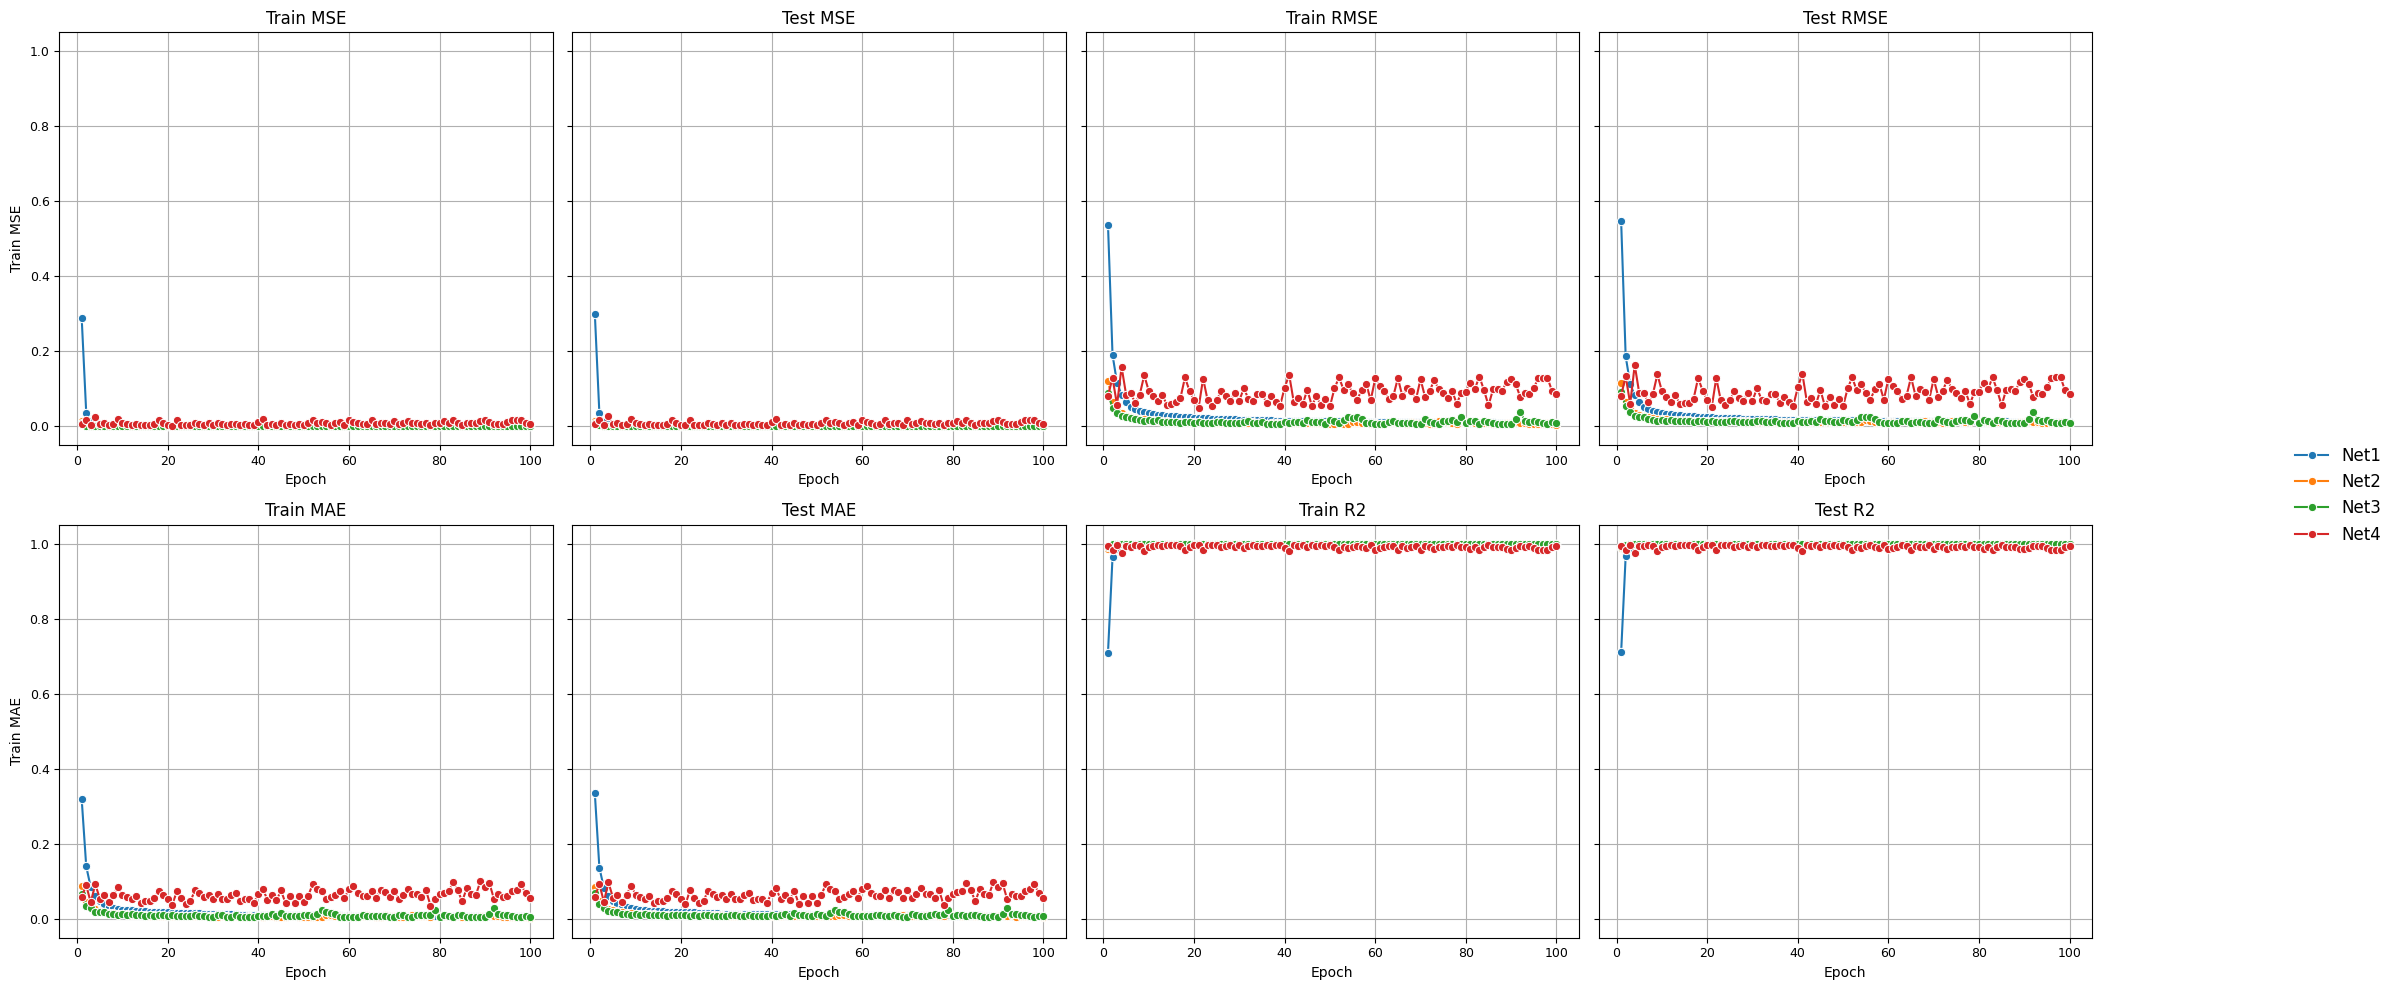

In [21]:
train_figures = {}
metrics_to_plot = ["Train MSE", "Test MSE", "Train RMSE", "Test RMSE", 
                   "Train MAE", "Test MAE", "Train R2", "Test R2"]

fig, axes = plt.subplots(2, 4, figsize=(24, 10), sharey=True)
axes = axes.flatten()

handles, labels = None, None

for i, metric in enumerate(metrics_to_plot):
    ax = axes[i]
    sns.lineplot(data=nn_metrics_df, x="Epoch", y=metric, hue="Model", marker='o', ax=ax)
    ax.set_title(metric, fontsize=12)
    ax.set_xlabel("Epoch", fontsize=10)
    ax.set_ylabel(metric if i % 4 == 0 else "", fontsize=10) 
    ax.grid(True)
    ax.tick_params(labelsize=9)

    if handles is None and ax.get_legend():
        handles, labels = ax.get_legend_handles_labels()

    if ax.get_legend():
        ax.get_legend().remove()

if handles and labels:
    fig.legend(handles, labels, loc='center right', fontsize="large", frameon=False)

plt.tight_layout(rect=[0, 0, 0.88, 1]) 
train_figures["Train_Metrics_Nets"] = fig

plt.show()
plt.close()

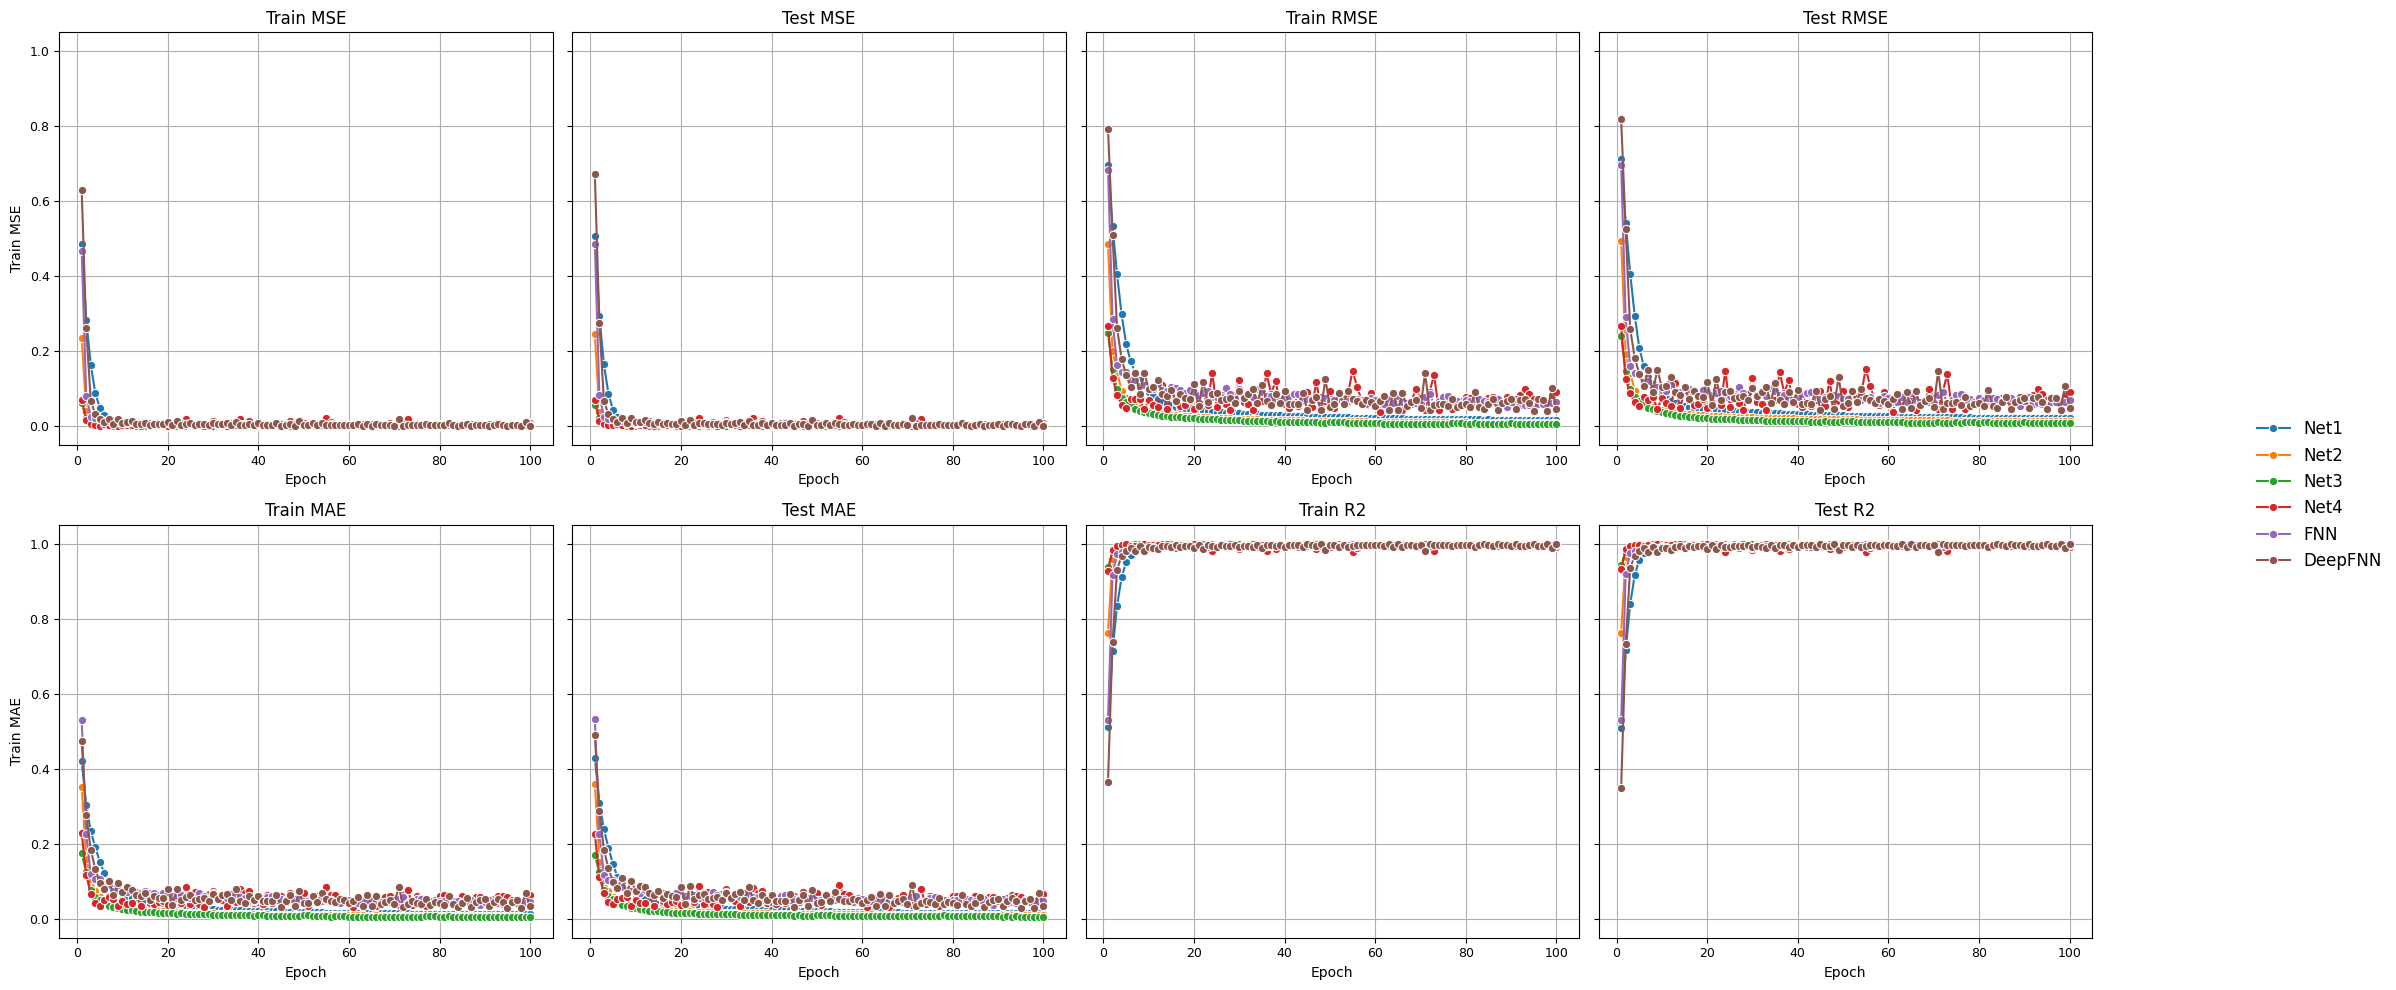

In [22]:
train_figures_tabular = {}

fig, axes = plt.subplots(2, 4, figsize=(24, 10), sharey=True)
axes = axes.flatten()

handles, labels = None, None

for i, metric in enumerate(metrics_to_plot):
    ax = axes[i]
    sns.lineplot(data=nn_metrics_df_tabular, x="Epoch", y=metric, hue="Model", marker='o', ax=ax)
    ax.set_title(metric, fontsize=12)
    ax.set_xlabel("Epoch", fontsize=10)
    ax.set_ylabel(metric if i % 4 == 0 else "", fontsize=10) 
    ax.grid(True)
    ax.tick_params(labelsize=9)

    if handles is None and ax.get_legend():
        handles, labels = ax.get_legend_handles_labels()

    if ax.get_legend():
        ax.get_legend().remove()

if handles and labels:
    fig.legend(handles, labels, loc='center right', fontsize="large", frameon=False)

plt.tight_layout(rect=[0, 0, 0.88, 1]) 

train_figures_tabular["Train_Metrics_Tabular"] = fig
plt.show()
plt.close()

In [23]:
X_train, X_test, y_train, y_test = train_test_split(
    X.values,         
    y.values,        
    test_size=0.2,
    shuffle=False
)

scaler_X = StandardScaler().fit(X_train)
X_train_scaled = scaler_X.transform(X_train)
X_test_scaled  = scaler_X.transform(X_test)

y_mean, y_std    = y_train.mean(), y_train.std()
y_train_norm     = (y_train - y_mean) / y_std
y_test_norm      = (y_test  - y_mean) / y_std

def create_sequence_data(X_arr, y_arr, seq_len=5):
    Xs, ys = [], []
    for i in range(len(X_arr) - seq_len):
        Xs.append(X_arr[i : i + seq_len])
        ys.append(y_arr[i + seq_len])
    return np.stack(Xs), np.stack(ys)

seq_len = 5
X_train_seq, y_train_seq = create_sequence_data(X_train_scaled, y_train_norm, seq_len)
X_test_seq,  y_test_seq  = create_sequence_data(X_test_scaled,  y_test_norm,  seq_len)

X_train_seq_tensor = torch.tensor(X_train_seq, dtype=torch.float32)  
y_train_seq_tensor = torch.tensor(y_train_seq, dtype=torch.float32).view(-1, 1)
X_test_seq_tensor  = torch.tensor(X_test_seq,  dtype=torch.float32)
y_test_seq_tensor  = torch.tensor(y_test_seq,  dtype=torch.float32).view(-1, 1)

train_loader_seq = DataLoader(
    TensorDataset(X_train_seq_tensor, y_train_seq_tensor),
    batch_size=64, shuffle=True
)
test_loader_seq  = DataLoader(
    TensorDataset(X_test_seq_tensor,  y_test_seq_tensor),
    batch_size=64, shuffle=False
)

In [24]:
in_channels = X_train_seq_tensor.shape[2]  

ts_nets = {
    "TCN":     TCN(in_channels, num_channels=[64,64]),
    "CNN1D":   CNN1D(in_channels, num_filters=32, num_layers=2, kernel_size=3, dropout=0.2),
    "GRUNet":  GRUNet(in_channels),
    "RNNNet":  RNNNet(in_channels),
    "CNNLSTM": CNNLSTM(in_channels),
    "BiLSTMNet":  BiLSTMNet(in_channels),
    "DeepLSTMNet":DeepLSTMNet(in_channels),
    "CNNBiLSTM":  CNNBiLSTM(in_channels),
    "GRUCNN":     GRUCNN(in_channels),
    "TCNLSTM":    TCNLSTM(in_channels),
    "Seq2SeqLSTM":Seq2SeqLSTM(in_channels),
}

In [25]:
results_ts = []
for name, net in ts_nets.items():
    results_ts += train_ts_model(
        name,
        net,
        train_loader_seq,       
        X_train_seq_tensor,     
        y_train_seq_tensor,     
        X_test_seq_tensor,      
        y_test_seq_tensor,      
        epochs=10,
        lr=1e-3
    )

nn_metrics_ts_df = pd.DataFrame(results_ts)

Training TCN:  10%|█████████                                                                                 | 1/10 [00:03<00:29,  3.31s/it]


Model: TCN | Epoch: 1/10
Train: MSE: 0.0550, RMSE: 0.2345, MAE: 0.1534, R2: 0.9451
Test:  MSE: 0.3275, RMSE: 0.5722, MAE: 0.4030, R2: 0.8664


Training TCN: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:29<00:00,  2.93s/it]



Model: TCN | Epoch: 10/10
Train: MSE: 0.0182, RMSE: 0.1350, MAE: 0.0775, R2: 0.9818
Test:  MSE: 0.0825, RMSE: 0.2872, MAE: 0.2272, R2: 0.9663


Training CNN1D:  10%|████████▊                                                                               | 1/10 [00:00<00:02,  4.30it/s]


Model: CNN1D | Epoch: 1/10
Train: MSE: 0.3123, RMSE: 0.5588, MAE: 0.3097, R2: 0.6882
Test:  MSE: 2.2904, RMSE: 1.5134, MAE: 1.4117, R2: 0.0657


Training CNN1D: 100%|███████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.40it/s]



Model: CNN1D | Epoch: 10/10
Train: MSE: 0.0278, RMSE: 0.1666, MAE: 0.0898, R2: 0.9723
Test:  MSE: 0.1767, RMSE: 0.4203, MAE: 0.2764, R2: 0.9279


Training GRUNet:  10%|████████▋                                                                              | 1/10 [00:00<00:02,  4.28it/s]


Model: GRUNet | Epoch: 1/10
Train: MSE: 0.2596, RMSE: 0.5095, MAE: 0.2852, R2: 0.7407
Test:  MSE: 1.8148, RMSE: 1.3472, MAE: 1.2570, R2: 0.2597


Training GRUNet: 100%|██████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.48it/s]



Model: GRUNet | Epoch: 10/10
Train: MSE: 0.0276, RMSE: 0.1661, MAE: 0.0970, R2: 0.9725
Test:  MSE: 0.1880, RMSE: 0.4336, MAE: 0.2581, R2: 0.9233


Training RNNNet:  10%|████████▋                                                                              | 1/10 [00:00<00:01,  7.85it/s]


Model: RNNNet | Epoch: 1/10
Train: MSE: 0.0385, RMSE: 0.1962, MAE: 0.1186, R2: 0.9615
Test:  MSE: 0.0625, RMSE: 0.2500, MAE: 0.2383, R2: 0.9745


Training RNNNet: 100%|██████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.49it/s]



Model: RNNNet | Epoch: 10/10
Train: MSE: 0.0159, RMSE: 0.1260, MAE: 0.0643, R2: 0.9841
Test:  MSE: 0.0434, RMSE: 0.2084, MAE: 0.1635, R2: 0.9823


Training CNNLSTM:  10%|████████▌                                                                             | 1/10 [00:03<00:35,  3.96s/it]


Model: CNNLSTM | Epoch: 1/10
Train: MSE: 0.4317, RMSE: 0.6570, MAE: 0.3758, R2: 0.5689
Test:  MSE: 2.9770, RMSE: 1.7254, MAE: 1.5822, R2: -0.2144


Training CNNLSTM: 100%|█████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:35<00:00,  3.60s/it]



Model: CNNLSTM | Epoch: 10/10
Train: MSE: 0.0528, RMSE: 0.2299, MAE: 0.1302, R2: 0.9472
Test:  MSE: 0.0458, RMSE: 0.2139, MAE: 0.1648, R2: 0.9813


Training BiLSTMNet:  10%|████████▍                                                                           | 1/10 [00:00<00:04,  1.99it/s]


Model: BiLSTMNet | Epoch: 1/10
Train: MSE: 0.2782, RMSE: 0.5274, MAE: 0.2865, R2: 0.7222
Test:  MSE: 2.1707, RMSE: 1.4733, MAE: 1.2030, R2: 0.1145


Training BiLSTMNet: 100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.06it/s]



Model: BiLSTMNet | Epoch: 10/10
Train: MSE: 0.0262, RMSE: 0.1620, MAE: 0.0844, R2: 0.9738
Test:  MSE: 0.2848, RMSE: 0.5337, MAE: 0.3306, R2: 0.8838


Training DeepLSTMNet:  10%|████████▏                                                                         | 1/10 [00:00<00:07,  1.28it/s]


Model: DeepLSTMNet | Epoch: 1/10
Train: MSE: 0.1450, RMSE: 0.3808, MAE: 0.2001, R2: 0.8552
Test:  MSE: 0.1526, RMSE: 0.3906, MAE: 0.3305, R2: 0.9378


Training DeepLSTMNet: 100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:08<00:00,  1.21it/s]



Model: DeepLSTMNet | Epoch: 10/10
Train: MSE: 0.0433, RMSE: 0.2081, MAE: 0.1197, R2: 0.9567
Test:  MSE: 0.3301, RMSE: 0.5746, MAE: 0.3632, R2: 0.8653


Training CNNBiLSTM:  10%|████████▍                                                                           | 1/10 [00:00<00:05,  1.61it/s]


Model: CNNBiLSTM | Epoch: 1/10
Train: MSE: 0.2880, RMSE: 0.5366, MAE: 0.3026, R2: 0.7124
Test:  MSE: 1.9886, RMSE: 1.4102, MAE: 1.2361, R2: 0.1888


Training CNNBiLSTM: 100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.60it/s]



Model: CNNBiLSTM | Epoch: 10/10
Train: MSE: 0.0253, RMSE: 0.1591, MAE: 0.0837, R2: 0.9747
Test:  MSE: 0.0682, RMSE: 0.2611, MAE: 0.2015, R2: 0.9722


Training GRUCNN:  10%|████████▋                                                                              | 1/10 [00:00<00:02,  3.19it/s]


Model: GRUCNN | Epoch: 1/10
Train: MSE: 0.2220, RMSE: 0.4712, MAE: 0.2628, R2: 0.7783
Test:  MSE: 1.5766, RMSE: 1.2556, MAE: 1.1415, R2: 0.3569


Training GRUCNN: 100%|██████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  3.27it/s]



Model: GRUCNN | Epoch: 10/10
Train: MSE: 0.0362, RMSE: 0.1904, MAE: 0.1017, R2: 0.9638
Test:  MSE: 0.2394, RMSE: 0.4893, MAE: 0.3530, R2: 0.9023


Training TCNLSTM:  10%|████████▌                                                                             | 1/10 [00:03<00:27,  3.05s/it]


Model: TCNLSTM | Epoch: 1/10
Train: MSE: 0.0487, RMSE: 0.2208, MAE: 0.1320, R2: 0.9513
Test:  MSE: 0.0128, RMSE: 0.1130, MAE: 0.0916, R2: 0.9948


Training TCNLSTM: 100%|█████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:30<00:00,  3.06s/it]



Model: TCNLSTM | Epoch: 10/10
Train: MSE: 0.0177, RMSE: 0.1329, MAE: 0.0757, R2: 0.9824
Test:  MSE: 0.0194, RMSE: 0.1391, MAE: 0.1203, R2: 0.9921


Training Seq2SeqLSTM:  10%|████████▏                                                                         | 1/10 [00:00<00:03,  2.35it/s]


Model: Seq2SeqLSTM | Epoch: 1/10
Train: MSE: 0.2702, RMSE: 0.5198, MAE: 0.2854, R2: 0.7302
Test:  MSE: 2.0170, RMSE: 1.4202, MAE: 1.2042, R2: 0.1772


Training Seq2SeqLSTM: 100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.70it/s]


Model: Seq2SeqLSTM | Epoch: 10/10
Train: MSE: 0.0315, RMSE: 0.1775, MAE: 0.0963, R2: 0.9685
Test:  MSE: 0.3665, RMSE: 0.6054, MAE: 0.3617, R2: 0.8505


In [26]:
best_idx = nn_metrics_ts_df.groupby("Model")["Test R2"].idxmax()
best_results_ts = nn_metrics_ts_df.loc[best_idx].reset_index(drop=True)
best_results_ts = best_results_ts[cols]
best_results_ts

Model  Epoch  Train MSE  Test MSE  Train RMSE  Test RMSE  Train MAE  \
0     BiLSTMNet      8   0.034306  0.258148    0.185220   0.508083   0.101620   
1         CNN1D      8   0.031702  0.168635    0.178051   0.410652   0.095154   
2     CNNBiLSTM      8   0.028216  0.042056    0.167976   0.205076   0.090059   
3       CNNLSTM      8   0.063587  0.041396    0.252165   0.203460   0.162798   
4   DeepLSTMNet      8   0.045009  0.118783    0.212153   0.344648   0.111374   
5        GRUCNN      8   0.032614  0.173855    0.180594   0.416959   0.092587   
6        GRUNet      2   0.085312  0.129887    0.292082   0.360399   0.169289   
7        RNNNet      8   0.018545  0.021544    0.136180   0.146777   0.072581   
8   Seq2SeqLSTM      9   0.042129  0.226989    0.205252   0.476433   0.111111   
9           TCN      5   0.025218  0.042015    0.158801   0.204976   0.089563   
10      TCNLSTM      4   0.027627  0.012744    0.166215   0.112891   0.099282   

    Test MAE  Train R2   Test R2  
0   0.331481  0.965739  0.894695  
1   0.309303  0.968340  0.931210  
2   0.155636  0.971822  0.982844  
3   0.146592  0.936497  0.983114  
4   0.224369  0.955051  0.951546  
5   0.336690  0.967429  0.929080  
6   0.280922  0.914801  0.947016  
7   0.116432  0.981479  0.991212  
8   0.307704  0.957927  0.907406  
9   0.163619  0.974816  0.982861  
10  0.089260  0.972409  0.994801

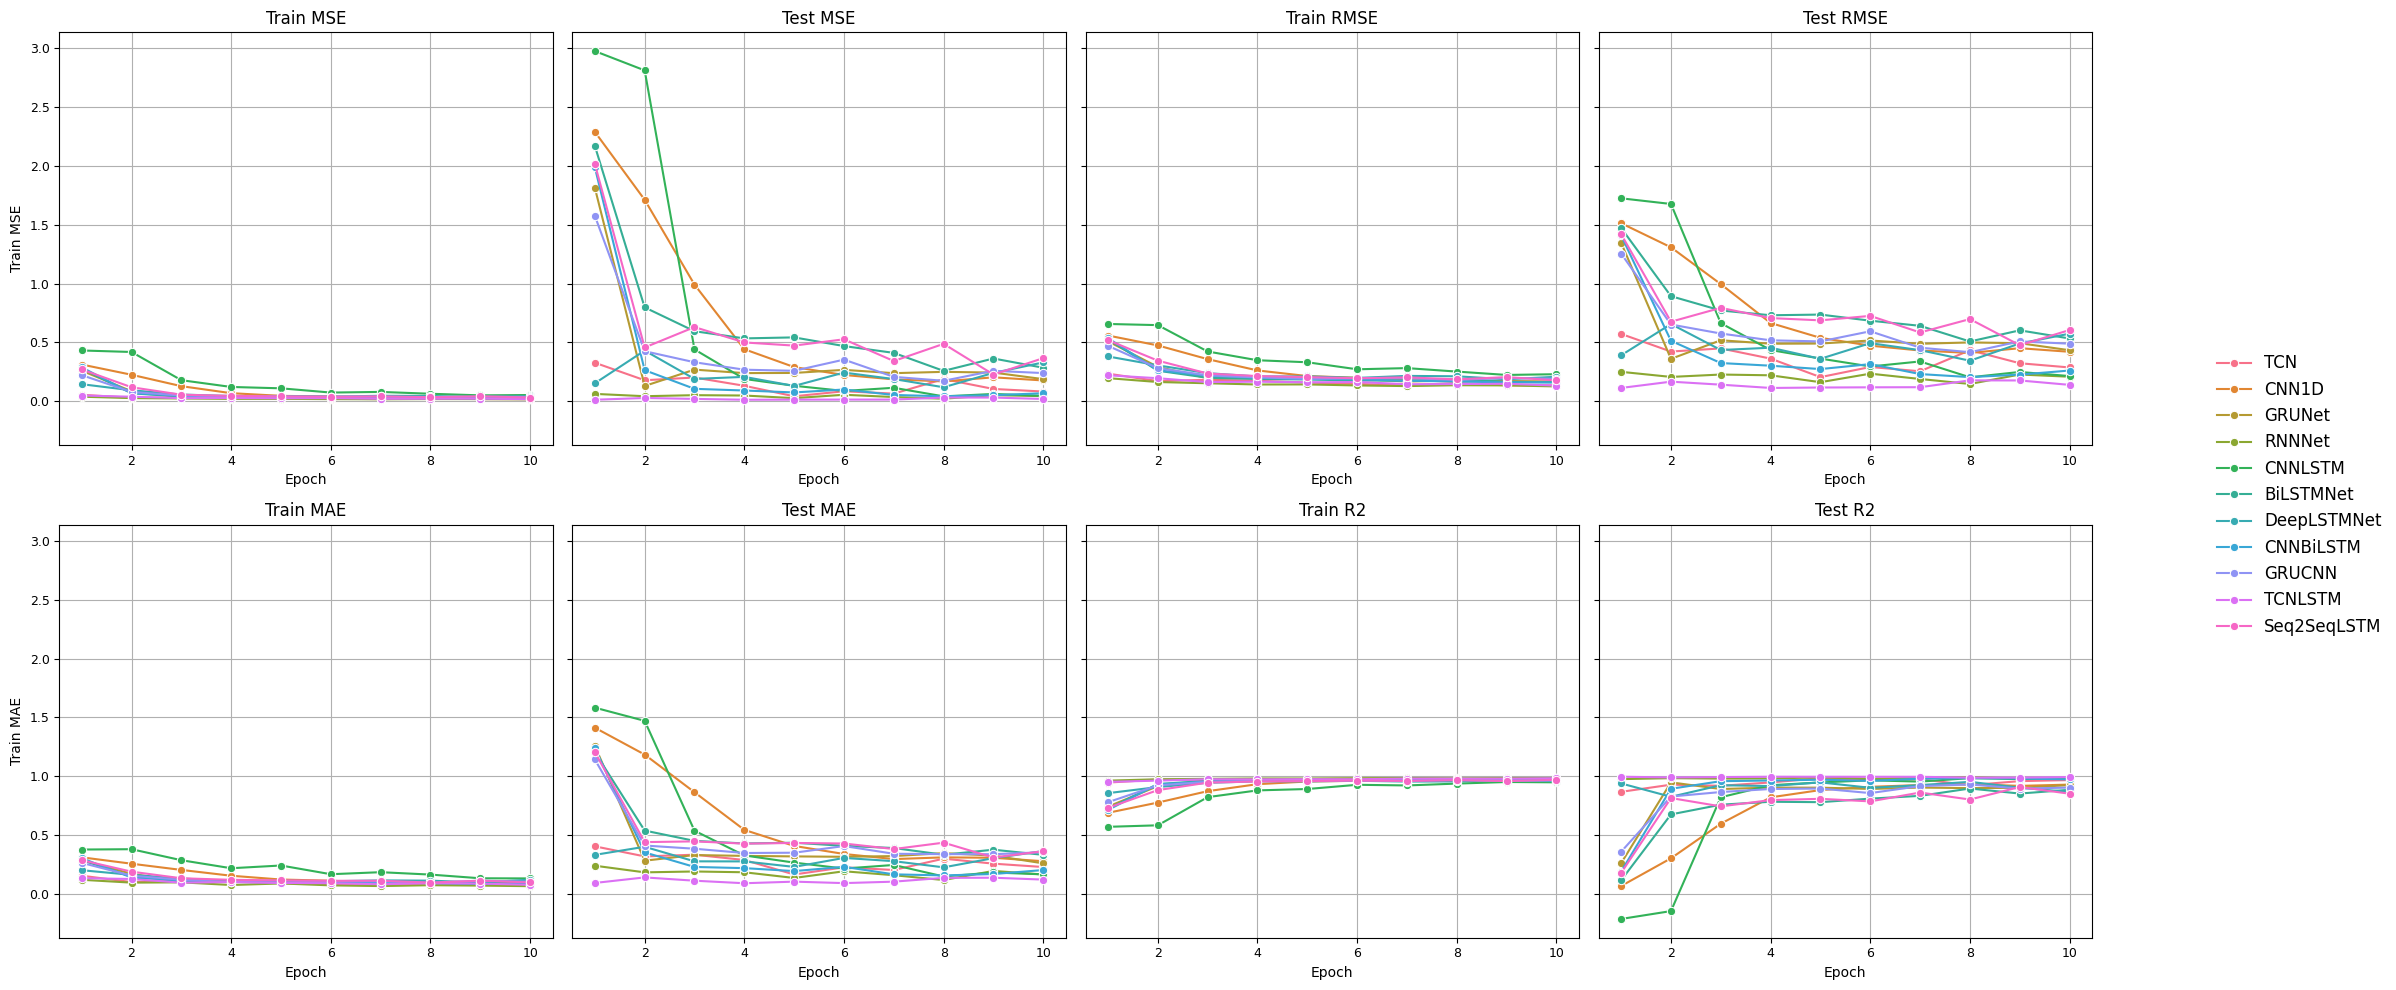

In [27]:
train_figures_ts = {}

models = ["TCN", "CNN1D", "GRUNet", "RNNNet", "CNNLSTM", "BiLSTMNet", "DeepLSTMNet", "CNNBiLSTM", "GRUCNN", "TCNLSTM", "Seq2SeqLSTM"]
df_models = nn_metrics_ts_df[nn_metrics_ts_df["Model"].isin(models)]

fig, axes = plt.subplots(2, 4, figsize=(24, 10), sharey=True)
axes = axes.flatten()

handles, labels = None, None

for i, metric in enumerate(metrics_to_plot):
    ax = axes[i]
    sns.lineplot(data=df_models, x="Epoch", y=metric, hue="Model", marker='o', ax=ax)
    ax.set_title(metric, fontsize=12)
    ax.set_xlabel("Epoch", fontsize=10)
    ax.set_ylabel(metric if i % 4 == 0 else "", fontsize=10) 
    ax.grid(True)
    ax.tick_params(labelsize=9)

    if handles is None and ax.get_legend():
        handles, labels = ax.get_legend_handles_labels()

    if ax.get_legend():
        ax.get_legend().remove()

if handles and labels:
    fig.legend(handles, labels, loc='center right', fontsize="large", frameon=False)

plt.tight_layout(rect=[0, 0, 0.88, 1]) 

train_figures_ts["Train_Metrics_TS"] = fig
plt.show()
plt.close()


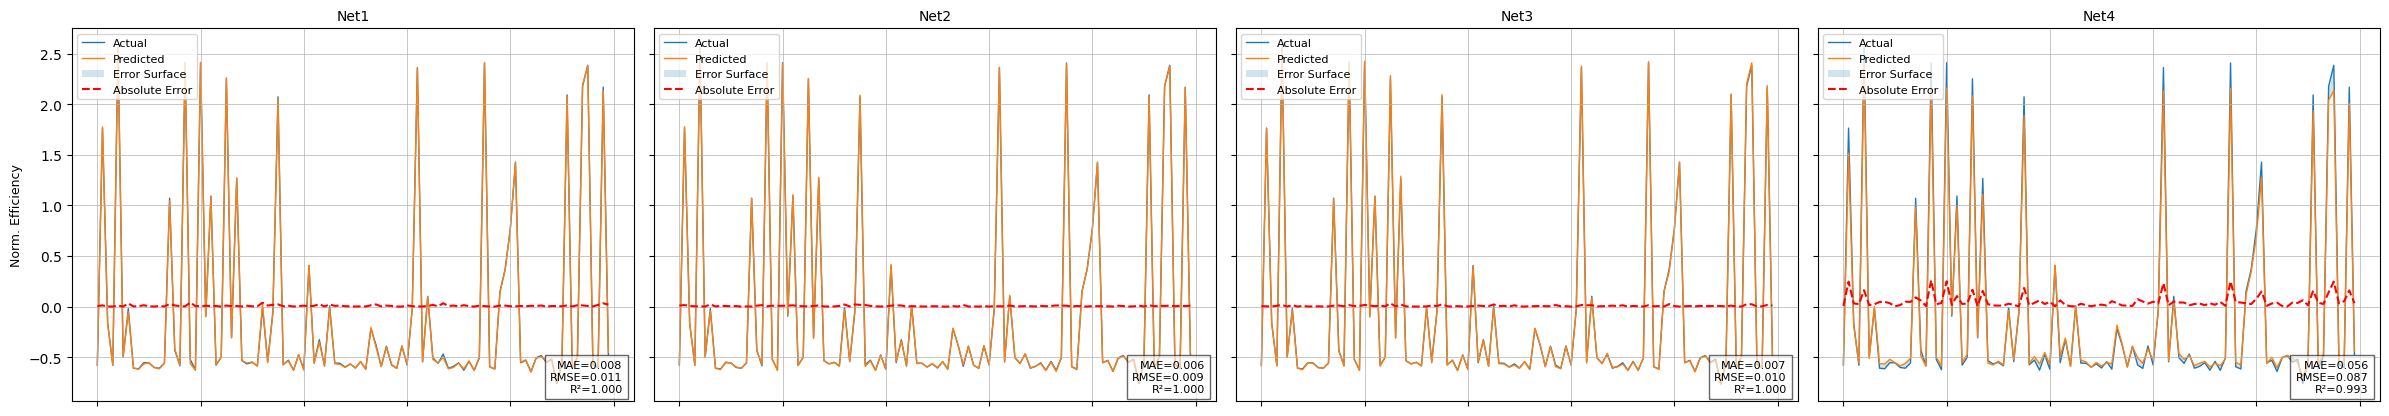

In [28]:
pred_figures_nets = {}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_models = len(nets)
ncols, nrows = 4, 4
fig, axes = plt.subplots(nrows, ncols, figsize=(24, 16),
                         sharex=True, sharey=True)
axes = axes.flatten()

desired = 100   
max_pts = 100

last_row_start = nrows * ncols - ncols
offset = (ncols - n_models % ncols) // 2 if n_models % ncols != 0 else 0

for i, (name, model) in enumerate(nets.items()):
    row = i // ncols
    col = i % ncols
    if row == nrows - 1 and n_models % ncols != 0:
        col += offset
    ax_index = row * ncols + col
    ax = axes[ax_index]

    model = model.to(device).eval()
    with torch.no_grad():
        X_in = reshape_input(model, X_test_tensor.to(device))
        preds = model(X_in).cpu().numpy().flatten()
        trues = y_test_tensor.cpu().numpy().flatten()

    avail = trues.shape[0]
    n_samples = min(desired, avail)
    y_t = trues[-n_samples:]
    y_p = preds[-n_samples:]
    err = np.abs(y_t - y_p)

    idx = np.linspace(0, n_samples - 1, min(n_samples, max_pts), dtype=int)

    ax.plot(idx, y_t[idx], label="Actual", lw=1, zorder=1)
    ax.plot(idx, y_p[idx], label="Predicted", lw=1, zorder=1)
    ax.fill_between(idx, y_t[idx], y_p[idx], alpha=0.2, label="Error Surface", zorder=0)
    ax.plot(idx, err[idx], '--', lw=1.5, color='red', label="Absolute Error", zorder=3)

    m = (nn_metrics_df.query("Model == @name").sort_values("Epoch").iloc[-1])
    stats = f"MAE={m['Test MAE']:.3f}\nRMSE={m['Test RMSE']:.3f}\nR²={m['Test R2']:.3f}"
    ax.text(0.98, 0.02, stats, transform=ax.transAxes,
            ha='right', va='bottom', fontsize=8,
            bbox=dict(facecolor='white', alpha=0.6))

    ax.set_title(name, fontsize=10)
    ax.grid(True, linewidth=0.5)

    if col == 0:
        ax.set_ylabel("Norm. Efficiency", fontsize=9)
    if row == nrows - 1:
        ax.set_xlabel("Sample Index", fontsize=9)

    ax.legend(fontsize=8, loc="upper left")

for j in range(n_models, nrows * ncols):
    fig.delaxes(axes[j])

plt.tight_layout()
pred_figures_nets["Prediction_Nets"] = fig
plt.show()
plt.close()


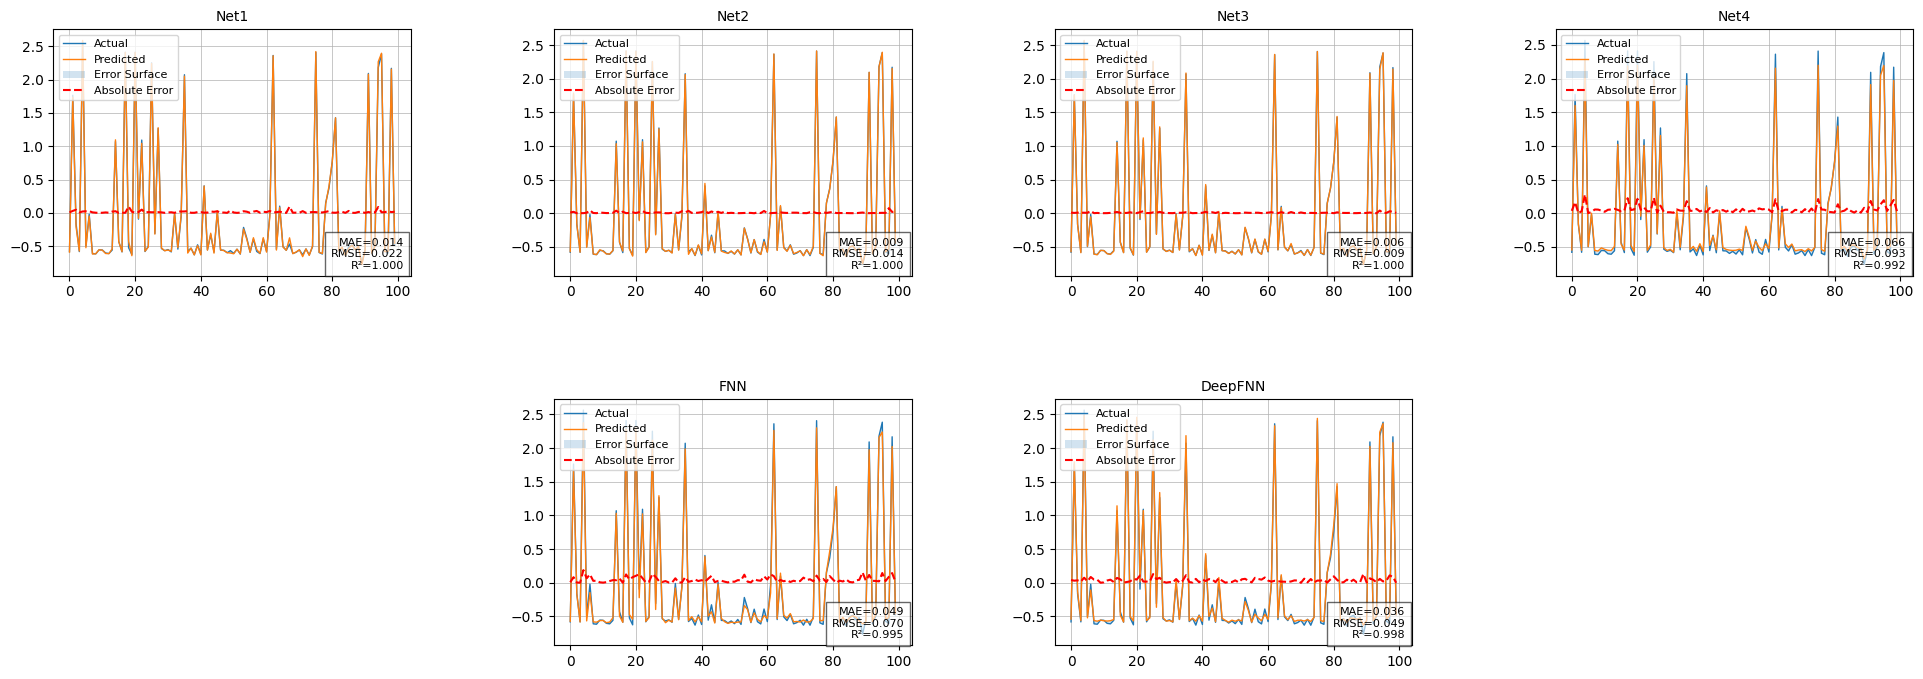

In [29]:
warnings.filterwarnings('ignore')

pred_figures_nets_tab = {}

n_models = len(nets_tabular)
ncols = 4
nrows = (n_models + ncols - 1) // ncols

fig = plt.figure(figsize=(6 * ncols, 4 * nrows))
gs = gridspec.GridSpec(nrows, ncols)
gs.update(wspace=0.4, hspace=0.5)

axes = []

model_items = list(nets_tabular.items())
i = 0

for row in range(nrows):
    remaining = n_models - i
    plots_in_row = min(ncols, remaining)

    if plots_in_row < ncols:
        start = (ncols - plots_in_row) // 2
    else:
        start = 0

    for j in range(plots_in_row):
        col_span = 1
        ax = fig.add_subplot(gs[row, start + j])
        axes.append((ax, model_items[i][0], model_items[i][1]))  
        i += 1

for ax, name, model in axes:
    model = model.to(device).eval()
    with torch.no_grad():
        X_in = reshape_input(model, X_test_tensor.to(device))
        preds = model(X_in).cpu().numpy().flatten()
        trues = y_test_tensor.cpu().numpy().flatten()

    avail = trues.shape[0]
    n_samples = min(100, avail)
    y_t = trues[-n_samples:]
    y_p = preds[-n_samples:]
    err = np.abs(y_t - y_p)
    idx = np.linspace(0, n_samples - 1, min(n_samples, 100), dtype=int)

    ax.plot(idx, y_t[idx], label="Actual", lw=1)
    ax.plot(idx, y_p[idx], label="Predicted", lw=1)
    ax.fill_between(idx, y_t[idx], y_p[idx], alpha=0.2, label="Error Surface")
    ax.plot(idx, err[idx], '--', lw=1.5, color='red', label="Absolute Error")

    m = nn_metrics_df_tabular.query("Model == @name").sort_values("Epoch").iloc[-1]
    stats = f"MAE={m['Test MAE']:.3f}\nRMSE={m['Test RMSE']:.3f}\nR²={m['Test R2']:.3f}"
    ax.text(0.98, 0.02, stats, transform=ax.transAxes,
            ha='right', va='bottom', fontsize=8,
            bbox=dict(facecolor='white', alpha=0.6))

    ax.set_title(name, fontsize=10)
    ax.grid(True, linewidth=0.5)
    ax.legend(fontsize=8, loc="upper left")

plt.tight_layout()
pred_figures_nets_tab["Prediction_Nets_Tab"] = fig
plt.show()
plt.close()

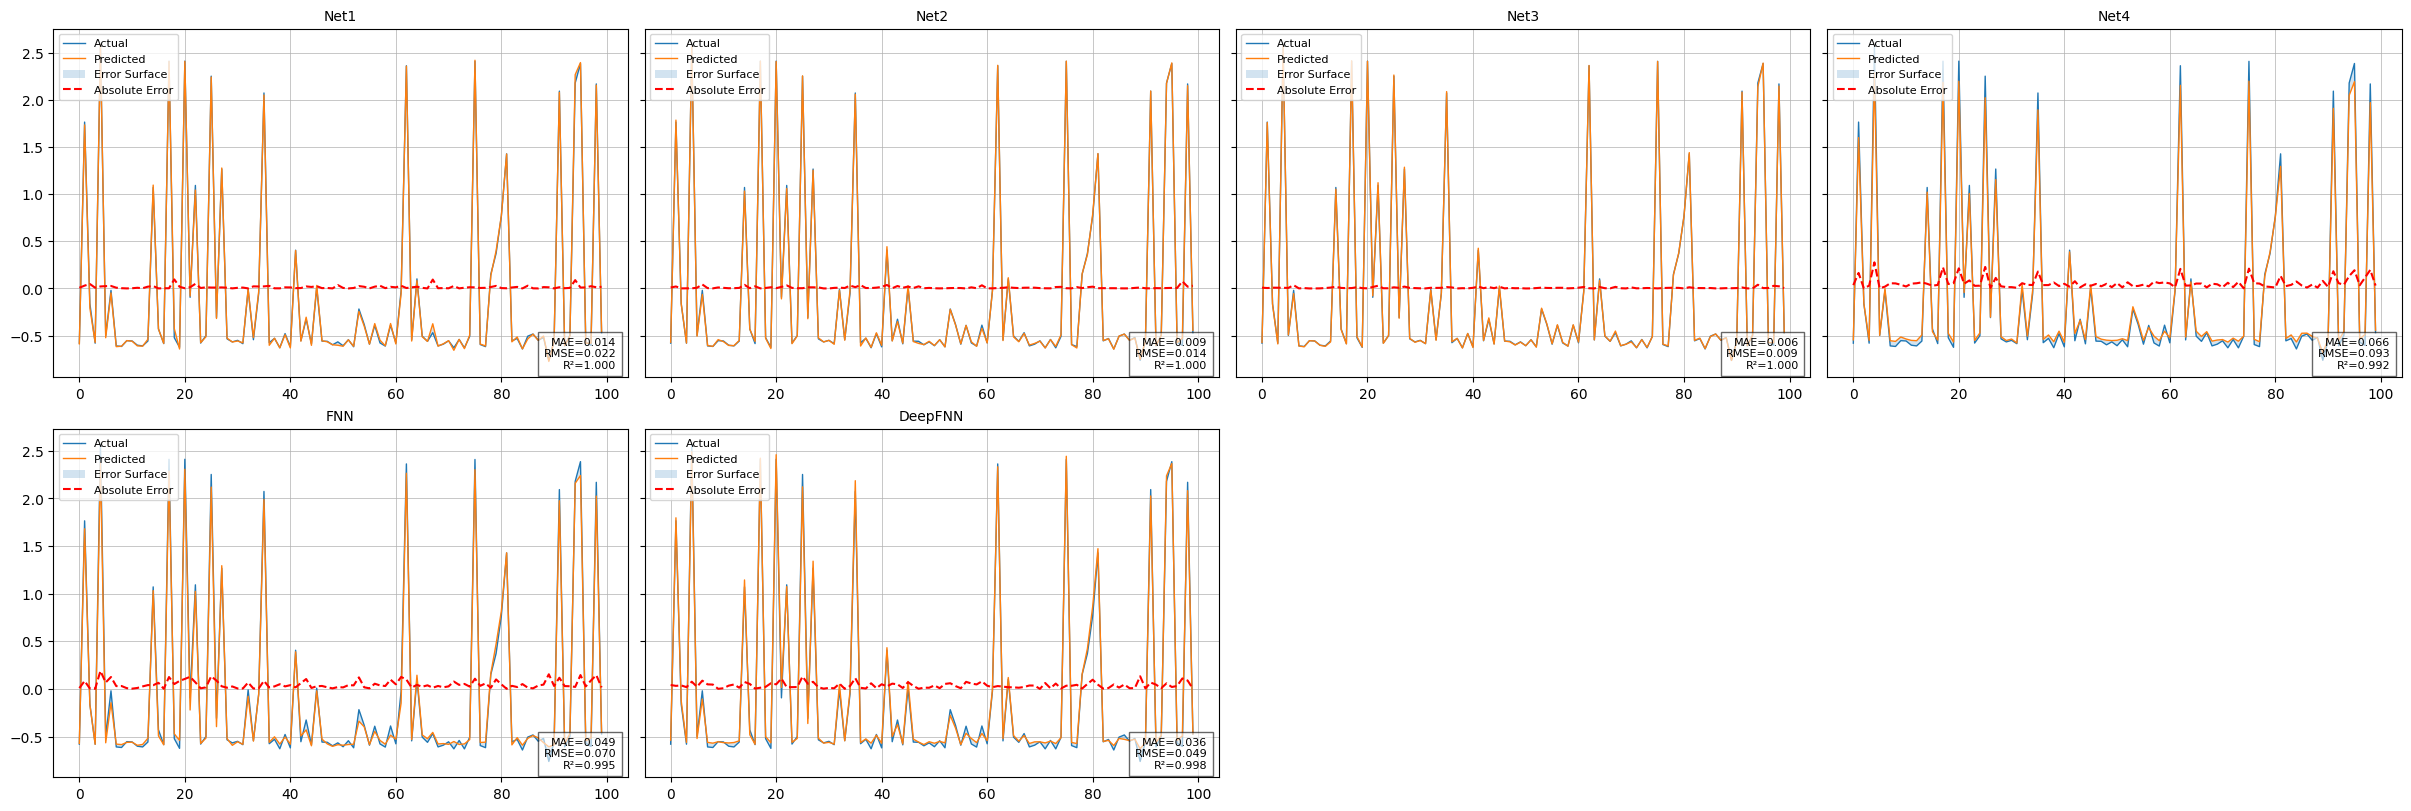

In [30]:
import warnings
import matplotlib.pyplot as plt
import numpy as np

warnings.filterwarnings('ignore')

pred_figures_nets_tab = {}

n_models = len(nets_tabular)
ncols = 4
nrows = (n_models + ncols - 1) // ncols

# Create figure with subplots
fig, axs = plt.subplots(nrows, ncols, figsize=(6 * ncols, 4 * nrows),
                       constrained_layout=True, squeeze=False,
                       sharey='row')  # Share y-axis within each row

axs_flat = axs.ravel()  # Flatten the array for easy iteration

# First pass to collect all y-axis limits for each row
row_ylims = []
for row in range(nrows):
    row_min = np.inf
    row_max = -np.inf
    for col in range(ncols):
        idx = row * ncols + col
        if idx >= n_models:
            continue
        
        name, model = list(nets_tabular.items())[idx]
        model = model.to(device).eval()
        with torch.no_grad():
            X_in = reshape_input(model, X_test_tensor.to(device))
            preds = model(X_in).cpu().numpy().flatten()
            trues = y_test_tensor.cpu().numpy().flatten()
        
        avail = trues.shape[0]
        n_samples = min(100, avail)
        y_t = trues[-n_samples:]
        y_p = preds[-n_samples:]
        
        current_min = min(np.min(y_t), np.min(y_p))
        current_max = max(np.max(y_t), np.max(y_p))
        
        row_min = min(row_min, current_min)
        row_max = max(row_max, current_max)
    
    # Add some padding
    padding = (row_max - row_min) * 0.05
    row_ylims.append((row_min - padding, row_max + padding))

# Second pass to actually plot with shared y-axes
for i, (name, model) in enumerate(nets_tabular.items()):
    row = i // ncols
    col = i % ncols
    ax = axs[row, col]
    
    # Model prediction
    model = model.to(device).eval()
    with torch.no_grad():
        X_in = reshape_input(model, X_test_tensor.to(device))
        preds = model(X_in).cpu().numpy().flatten()
        trues = y_test_tensor.cpu().numpy().flatten()

    # Prepare data for plotting
    avail = trues.shape[0]
    n_samples = min(100, avail)
    y_t = trues[-n_samples:]
    y_p = preds[-n_samples:]
    err = np.abs(y_t - y_p)
    idx = np.linspace(0, n_samples - 1, min(n_samples, 100), dtype=int)

    # Plotting
    ax.plot(idx, y_t[idx], label="Actual", lw=1)
    ax.plot(idx, y_p[idx], label="Predicted", lw=1)
    ax.fill_between(idx, y_t[idx], y_p[idx], alpha=0.2, label="Error Surface")
    ax.plot(idx, err[idx], '--', lw=1.5, color='red', label="Absolute Error")

    # Add metrics text
    m = nn_metrics_df_tabular.query("Model == @name").sort_values("Epoch").iloc[-1]
    stats = f"MAE={m['Test MAE']:.3f}\nRMSE={m['Test RMSE']:.3f}\nR²={m['Test R2']:.3f}"
    ax.text(0.98, 0.02, stats, transform=ax.transAxes,
            ha='right', va='bottom', fontsize=8,
            bbox=dict(facecolor='white', alpha=0.6))

    ax.set_title(name, fontsize=10)
    ax.grid(True, linewidth=0.5)
    ax.legend(fontsize=8, loc="upper left")
    
    # Set y-axis limits for the row
    ax.set_ylim(row_ylims[row])

# Hide any unused subplots
for j in range(n_models, nrows * ncols):
    axs_flat[j].axis('off')

pred_figures_nets_tab["Prediction_Nets_Tab"] = fig
plt.show()
plt.close()

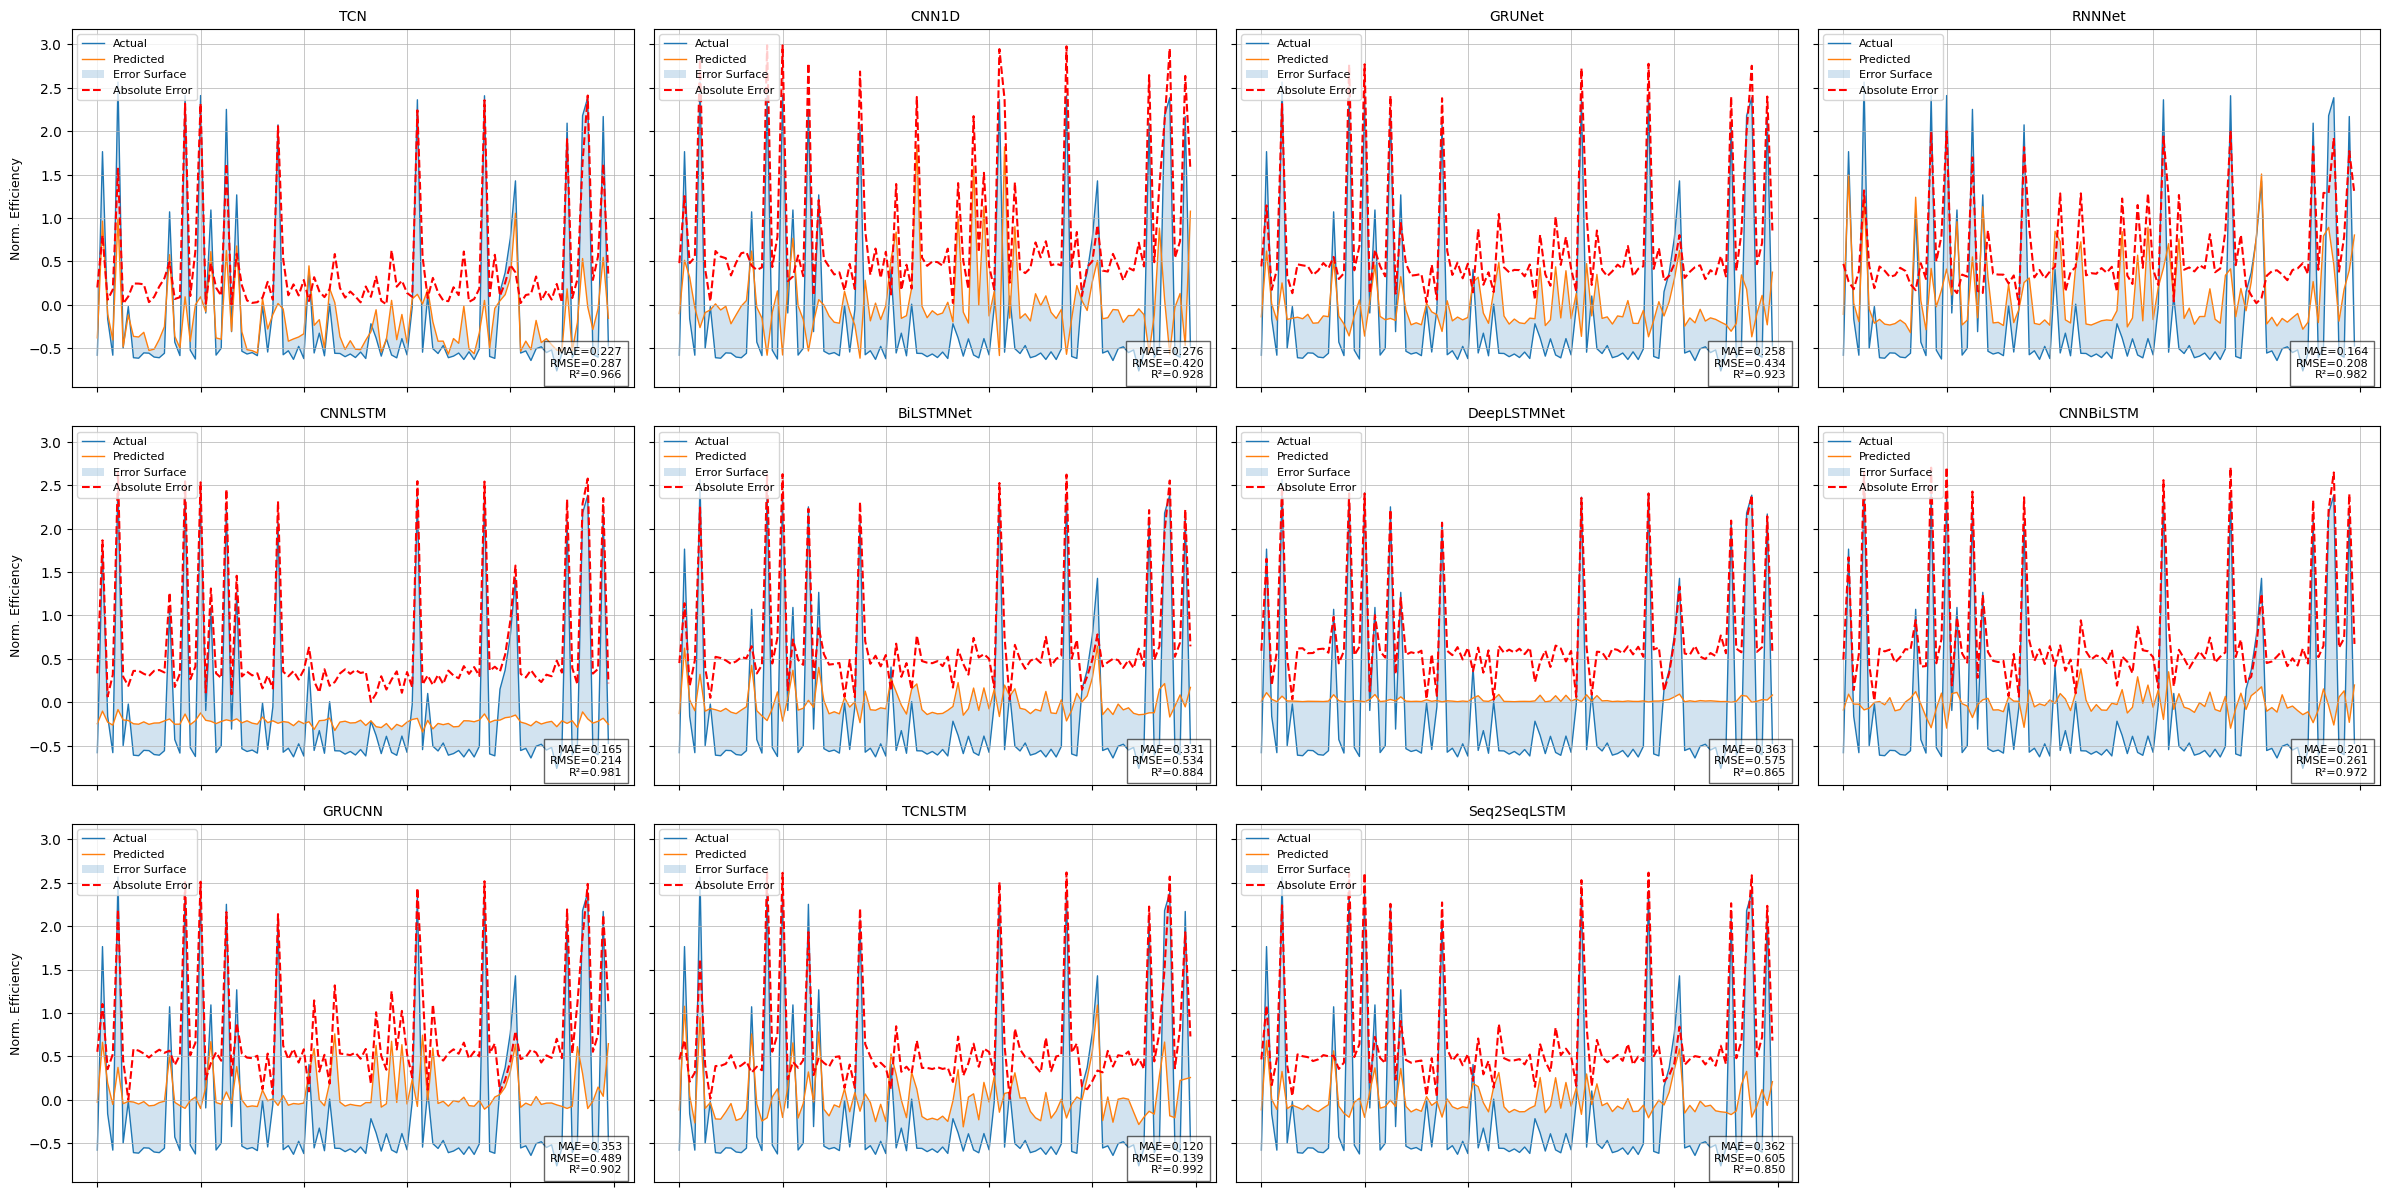

In [31]:
pred_figures_nets_ts = {}

n_models = len(ts_nets)
ncols, nrows = 4, 4
fig, axes = plt.subplots(nrows, ncols, figsize=(24, 16), sharex=True, sharey=True)
axes = axes.flatten()

desired = 100
max_pts = 100

positions = []
full_rows = n_models // ncols
remainder = n_models % ncols

for r in range(full_rows):
    for c in range(ncols):
        positions.append(r * ncols + c)

if remainder:
    offset = (ncols - remainder) // 2
    for c in range(remainder):
        positions.append((full_rows * ncols) + offset + c)

for i, (name, model) in enumerate(ts_nets.items()):
    ax = axes[positions[i]]
    model = model.to(device).eval()

    with torch.no_grad():
        X_in = reshape_input(model, X_test_tensor.to(device))
        preds = model(X_in).cpu().numpy().flatten()
        trues = y_test_tensor.cpu().numpy().flatten()

    avail = trues.shape[0]
    n_samples = min(desired, avail)
    y_t = trues[-n_samples:]
    y_p = preds[-n_samples:]
    err = np.abs(y_t - y_p)
    idx = np.linspace(0, n_samples - 1, min(n_samples, max_pts), dtype=int)

    ax.plot(idx, y_t[idx], label="Actual", lw=1, zorder=1)
    ax.plot(idx, y_p[idx], label="Predicted", lw=1, zorder=1)
    ax.fill_between(idx, y_t[idx], y_p[idx], alpha=0.2, label="Error Surface", zorder=0)
    ax.plot(idx, err[idx], '--', lw=1.5, color='red', label="Absolute Error", zorder=3)

    m = nn_metrics_ts_df.query("Model == @name").sort_values("Epoch").iloc[-1]
    stats = f"MAE={m['Test MAE']:.3f}\nRMSE={m['Test RMSE']:.3f}\nR²={m['Test R2']:.3f}"
    ax.text(0.98, 0.02, stats, transform=ax.transAxes,
            ha='right', va='bottom', fontsize=8,
            bbox=dict(facecolor='white', alpha=0.6))

    ax.set_title(name, fontsize=10)
    ax.grid(True, linewidth=0.5)

    if positions[i] % ncols == 0:
        ax.set_ylabel("Norm. Efficiency", fontsize=9)
    if positions[i] // ncols == nrows - 1:
        ax.set_xlabel("Sample Index", fontsize=9)

    ax.legend(fontsize=8, loc="upper left")

for j in range(n_models, nrows * ncols):
    fig.delaxes(axes[j])

plt.tight_layout()
pred_figures_nets_ts["Prediction_Nets_TS"] = fig
plt.show()
plt.close()


In [35]:
for name, model in nets.items():
    save_experiment(
        station="Amberd1",
        model_name=name,
        net=model,
        metrics_df=nn_metrics_df[nn_metrics_df["Model"] == name],
        train_figs=train_figures,
        pred_figs=pred_figures_nets,
        base_dir=Path("..")
    )

In [36]:
for name, model in nets_tabular.items():
    save_experiment(
        station="Amberd1",
        model_name=name,
        net=model,
        metrics_df=nn_metrics_df_tabular[nn_metrics_df_tabular["Model"] == name],
        train_figs=train_figures_tabular,
        pred_figs= pred_figures_nets_tab,
        base_dir=Path("..")
    )

In [ ]:
for name, model in ts_nets.items():
    save_experiment(
        station="Amberd1",
        model_name=name,
        net=model,
        metrics_df=nn_metrics_ts_df[nn_metrics_ts_df["Model"] == name],
        train_figs=train_figures_ts,
        pred_figs=pred_figures_nets_ts,
        base_dir=Path("..")
    )